In [1]:
# !pip install umap-learn gym stable-baselines3 ipywidgets

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

# Libraries for unsupervised learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

In [3]:
# For outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# For reinforcement learning
import gym
from gym import spaces
import stable_baselines3 as sb3
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy


In [4]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")

# Create models directory if it doesn't exist
import os
if not os.path.exists('unsupervised_models'):
    os.makedirs('unsupervised_models')
print("Starting unsupervised learning analysis...")

# Load datasets
analysis_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/nifty_2014_analysis_results.csv')
vix_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/NSE_INDIAVIX_2014.csv')
nifty_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/NSE_NIFTY_2014.csv')

# Display the first few rows of each dataset
print("Nifty Analysis Results:")
display(analysis_df.head())

print("\nIndia VIX Data:")
display(vix_df.head())

print("\nNifty Hourly Data:")
display(nifty_df.head())

Starting unsupervised learning analysis...
Nifty Analysis Results:


,monday_date,monday_day,monday_open,monday_low,monday_high,monday_close,monday_volume,expiry_date,expiry_day,expiry_open,expiry_low,expiry_high,expiry_close,expiry_volume,3_week_high,3_week_low,monday_close_minus_expiry_close,3_week_high_minus_monday_close,3_week_low_minus_monday_close,3_week_high_minus_thursday_close,3_week_low_minus_thursday_close
0,2014-08-18,Monday,7788.40,7779.20,7826.15,7822.95,0,2014-09-04,Thursday,8114.25,8081.00,8114.80,8089.00,0,8121.65,7779.20,-266.05,298.70,-43.75,32.65,-309.80
1,2014-08-25,Monday,7934.60,7927.75,7957.70,7940.55,0,2014-09-11,Thursday,8118.65,8096.25,8127.95,8114.75,0,8174.55,7871.65,-174.20,234.00,-68.90,59.80,-243.10
2,2014-09-01,Monday,7994.70,7984.00,8022.70,8019.80,0,2014-09-18,Thursday,7958.55,7939.70,8051.35,8037.00,0,8174.55,7936.95,-17.20,154.75,-82.85,137.55,-100.05
3,2014-09-08,Monday,8133.45,8126.15,8146.70,8146.20,0,2014-09-25,Thursday,8013.55,7980.70,8019.30,7990.05,0,8174.55,7936.95,156.15,28.35,-209.25,184.50,-53.10
4,2014-09-15,Monday,8077.30,8030.00,8077.30,8046.30,0,2014-10-01,Wednesday,7970.00,7948.40,7977.50,7962.40,0,8159.75,7884.85,83.90,113.45,-161.45,197.35,-77.55



India VIX Data:


,datetime,open,high,low,close
0,2014-09-09T09:15:00+05:30,12.7925,13.0075,11.0125,12.8700
1,2014-09-09T10:15:00+05:30,12.8650,13.0100,12.8300,12.9700
2,2014-09-09T11:15:00+05:30,12.9775,13.0425,12.8825,12.9275
3,2014-09-09T12:15:00+05:30,12.9325,12.9650,12.7700,12.9175
4,2014-09-09T13:15:00+05:30,12.9200,13.0050,12.8075,12.8550



Nifty Hourly Data:


,time,open,high,low,close,Volume,Volume MA
0,2014-08-12T10:15:00+05:30,7671.25,7673.95,7657.50,7669.9,0,0.0
1,2014-08-12T11:15:00+05:30,7670.35,7672.65,7657.10,7664.7,0,0.0
2,2014-08-12T12:15:00+05:30,7664.65,7669.30,7654.80,7663.9,0,0.0
3,2014-08-12T13:15:00+05:30,7664.05,7676.25,7661.30,7675.7,0,0.0
4,2014-08-12T14:15:00+05:30,7675.55,7730.70,7672.45,7723.7,0,0.0


In [5]:
# Convert date columns to datetime
analysis_df['monday_date'] = pd.to_datetime(analysis_df['monday_date'])
analysis_df['expiry_date'] = pd.to_datetime(analysis_df['expiry_date'])
vix_df['datetime'] = pd.to_datetime(vix_df['datetime'])

# Extract date from datetime for easier merging later
vix_df['date'] = vix_df['datetime'].dt.date
vix_df['date'] = pd.to_datetime(vix_df['date'])

# If nifty_df time column needs conversion
nifty_df['time'] = pd.to_datetime(nifty_df['time'])
nifty_df['date'] = nifty_df['time'].dt.date
nifty_df['date'] = pd.to_datetime(nifty_df['date'])

# Handle missing values
analysis_df = analysis_df.fillna(0)
vix_df = vix_df.dropna()
nifty_df = nifty_df.dropna()

# Merge VIX data with analysis_df (similar to supervised notebook)
vix_df['day_of_week'] = vix_df['datetime'].dt.dayofweek
vix_df['hour'] = vix_df['datetime'].dt.hour
monday_first_hour_vix = vix_df[(vix_df['day_of_week'] == 0) & (vix_df['hour'] == vix_df['datetime'].dt.hour.min())]

# Group by date to get one record per day
monday_vix = monday_first_hour_vix.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
}).rename(columns={'open': 'vix_open', 'high': 'vix_high', 'low': 'vix_low', 'close': 'vix_close'}).reset_index()

# Convert monday_date to date format for merging
analysis_df['monday_date_only'] = analysis_df['monday_date'].dt.date
analysis_df['monday_date_only'] = pd.to_datetime(analysis_df['monday_date_only'])

# Merge the dataframes
merged_df = pd.merge(analysis_df, monday_vix, left_on='monday_date_only', right_on='date', how='inner')
print(f"Merged DataFrame has {len(merged_df)} rows with both Nifty and VIX data")

Merged DataFrame has 512 rows with both Nifty and VIX data


In [6]:
# Feature engineering (similar to supervised notebook)
# Calculate range percentages
merged_df['range_3week'] = merged_df['3_week_high'] - merged_df['3_week_low']
merged_df['range_pct'] = merged_df['range_3week'] / merged_df['monday_close'] * 100
merged_df['high_range_pct'] = (merged_df['3_week_high'] - merged_df['monday_close']) / merged_df['monday_close'] * 100
merged_df['low_range_pct'] = (merged_df['monday_close'] - merged_df['3_week_low']) / merged_df['monday_close'] * 100

# Extract time-based features
merged_df['month'] = merged_df['monday_date'].dt.month
merged_df['year'] = merged_df['monday_date'].dt.year
merged_df['week_of_year'] = merged_df['monday_date'].dt.isocalendar().week
merged_df['day_of_year'] = merged_df['monday_date'].dt.dayofyear

# Calculate price momentum features
merged_df['weekly_change'] = merged_df['monday_close'].pct_change() * 100
merged_df['price_to_3wk_high_ratio'] = merged_df['monday_close'] / merged_df['3_week_high']
merged_df['price_to_3wk_low_ratio'] = merged_df['monday_close'] / merged_df['3_week_low']

# Calculate volatility features
merged_df['monday_range'] = (merged_df['monday_high'] - merged_df['monday_low']) / merged_df['monday_close'] * 100
merged_df['vix_range'] = (merged_df['vix_high'] - merged_df['vix_low']) / merged_df['vix_close'] * 100

# Create rolling window features
merged_df = merged_df.sort_values('monday_date')
merged_df['prev_week_range'] = merged_df['range_pct'].shift(1)
merged_df['prev_week_vix_close'] = merged_df['vix_close'].shift(1)
merged_df['vix_week_change'] = merged_df['vix_close'].pct_change() * 100

# Create more advanced features
merged_df['price_momentum'] = merged_df['monday_close'].pct_change(3) * 100  # 3-week momentum
merged_df['vix_momentum'] = merged_df['vix_close'].pct_change(3) * 100      # 3-week VIX momentum
merged_df['price_vix_ratio'] = merged_df['monday_close'] / merged_df['vix_close']

# Drop rows with NaN from new features
merged_df = merged_df.dropna()

# Display the enhanced dataset
print(merged_df.head())

  monday_date monday_day  monday_open  monday_low  monday_high  monday_close  monday_volume expiry_date expiry_day  expiry_open  expiry_low  expiry_high  expiry_close  expiry_volume  3_week_high  3_week_low  monday_close_minus_expiry_close  3_week_high_minus_monday_close  3_week_low_minus_monday_close  3_week_high_minus_thursday_close  3_week_low_minus_thursday_close monday_date_only       date  vix_open  vix_high  vix_low  vix_close  range_3week  range_pct  high_range_pct  low_range_pct  month  year  week_of_year  day_of_year  weekly_change  price_to_3wk_high_ratio  price_to_3wk_low_ratio  monday_range  vix_range  prev_week_range  prev_week_vix_close  vix_week_change  price_momentum  vix_momentum  price_vix_ratio
3  2014-10-13     Monday      7829.45     7796.00      7835.10       7817.20              0  2014-10-30   Thursday      8091.00     8088.55      8121.95       8117.10              0      8121.95     7729.65                          -299.90                          304.75     

In [7]:
# Create features for unsupervised learning
features = ['monday_close', 'monday_open', 'monday_high', 'monday_low', 'monday_volume',
           'vix_open', 'vix_high', 'vix_low', 'vix_close',
           'monday_range', 'vix_range', 'range_pct',
           'prev_week_range', 'prev_week_vix_close', 'vix_week_change',
           'price_momentum', 'vix_momentum', 'price_vix_ratio']

X = merged_df[features].copy()

# Normalize data for unsupervised learning
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for future use
joblib.dump(scaler, 'unsupervised_models/feature_scaler.pkl')
print("Feature scaler saved to 'unsupervised_models/feature_scaler.pkl'")

Feature scaler saved to 'unsupervised_models/feature_scaler.pkl'



========== Principal Component Analysis (PCA) ==========


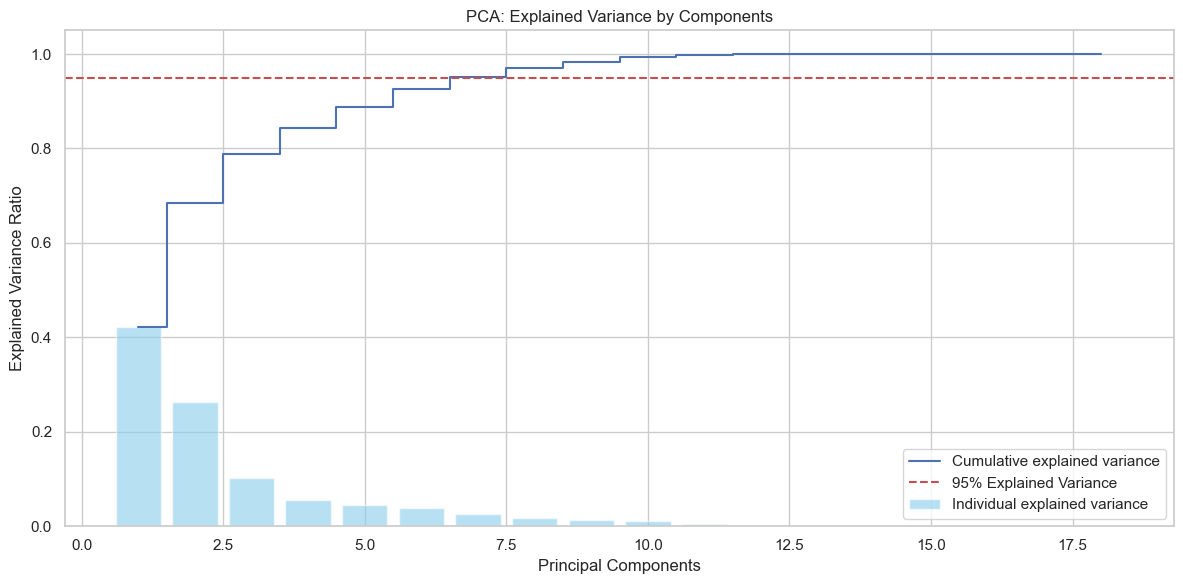

Number of components needed for 95% variance: 7
PCA model with 7 components saved to 'unsupervised_models/pca_model.pkl'


In [8]:
#####################################################
# Part 1: Principal Component Analysis (PCA)
#####################################################
print("\n========== Principal Component Analysis (PCA) ==========")

# Implement PCA
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Display explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='skyblue', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend(loc='best')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Explained Variance by Components')
plt.tight_layout()
plt.savefig('unsupervised_models/pca_explained_variance.png')
plt.show()

# Determine optimal number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components_95}")

# Apply PCA with optimal components
pca_optimal = PCA(n_components=n_components_95, random_state=42)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# Save the PCA model
joblib.dump(pca_optimal, 'unsupervised_models/pca_model.pkl')
print(f"PCA model with {n_components_95} components saved to 'unsupervised_models/pca_model.pkl'")

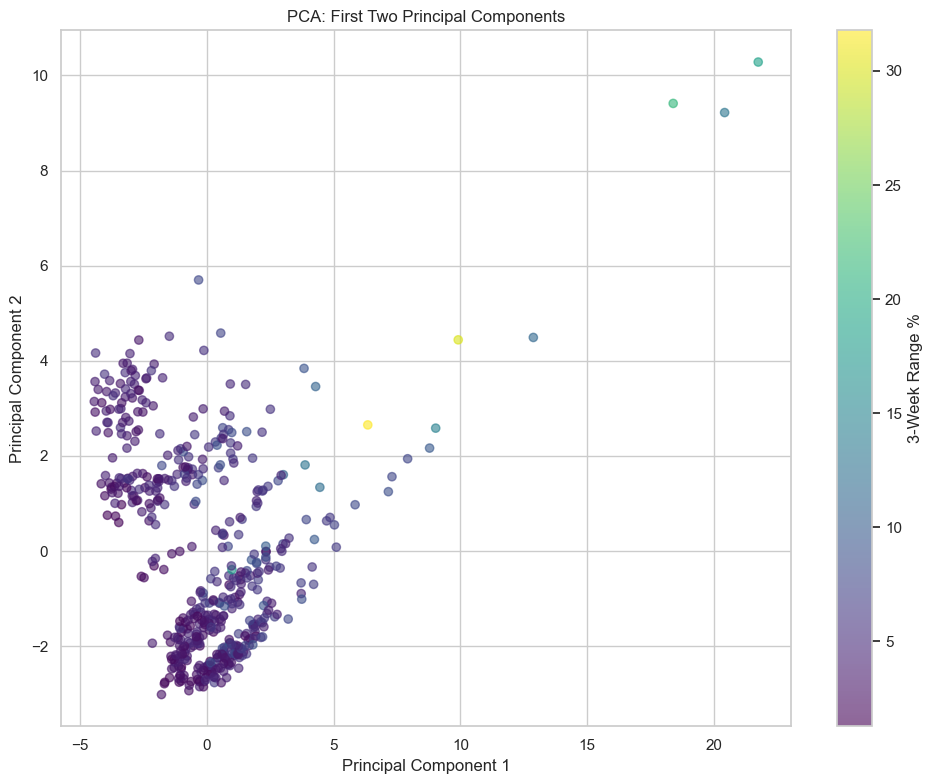


PCA Component Loadings (First Two Components):
                          PC1       PC2
monday_close        -0.208734  0.371882
monday_open         -0.208053  0.372514
monday_high         -0.207631  0.372917
monday_low          -0.209372  0.371266
monday_volume       -0.155074  0.335110
vix_open             0.320551  0.169251
vix_high             0.321124  0.180834
vix_low              0.311311  0.182996
vix_close            0.321423  0.176723
monday_range         0.223678  0.174688
vix_range            0.039227 -0.024167
range_pct            0.225647  0.136691
prev_week_range      0.254372  0.161469
prev_week_vix_close  0.285705  0.140039
vix_week_change      0.095850  0.092621
price_momentum      -0.141995 -0.115271
vix_momentum         0.193756  0.165252
price_vix_ratio     -0.283438  0.251049

Top features in PC1:
vix_close              0.321423
vix_high               0.321124
vix_open               0.320551
vix_low                0.311311
prev_week_vix_close    0.285705
Name: PC1,

In [9]:


# Visualize first two components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_df['range_pct'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='3-Week Range %')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components')
plt.tight_layout()
plt.savefig('unsupervised_models/pca_components_visualization.png')
plt.show()

# Display component loadings for interpretation
component_loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=features
)
print("\nPCA Component Loadings (First Two Components):")
print(component_loadings)

# Sort features by absolute loading values
top_features_pc1 = component_loadings['PC1'].abs().sort_values(ascending=False)
top_features_pc2 = component_loadings['PC2'].abs().sort_values(ascending=False)

print("\nTop features in PC1:")
print(top_features_pc1.head(5))
print("\nTop features in PC2:")
print(top_features_pc2.head(5))

# Save component loadings
component_loadings.to_csv('unsupervised_models/pca_component_loadings.csv')
print("PCA component loadings saved to 'unsupervised_models/pca_component_loadings.csv'")


========== K-Means Clustering ==========


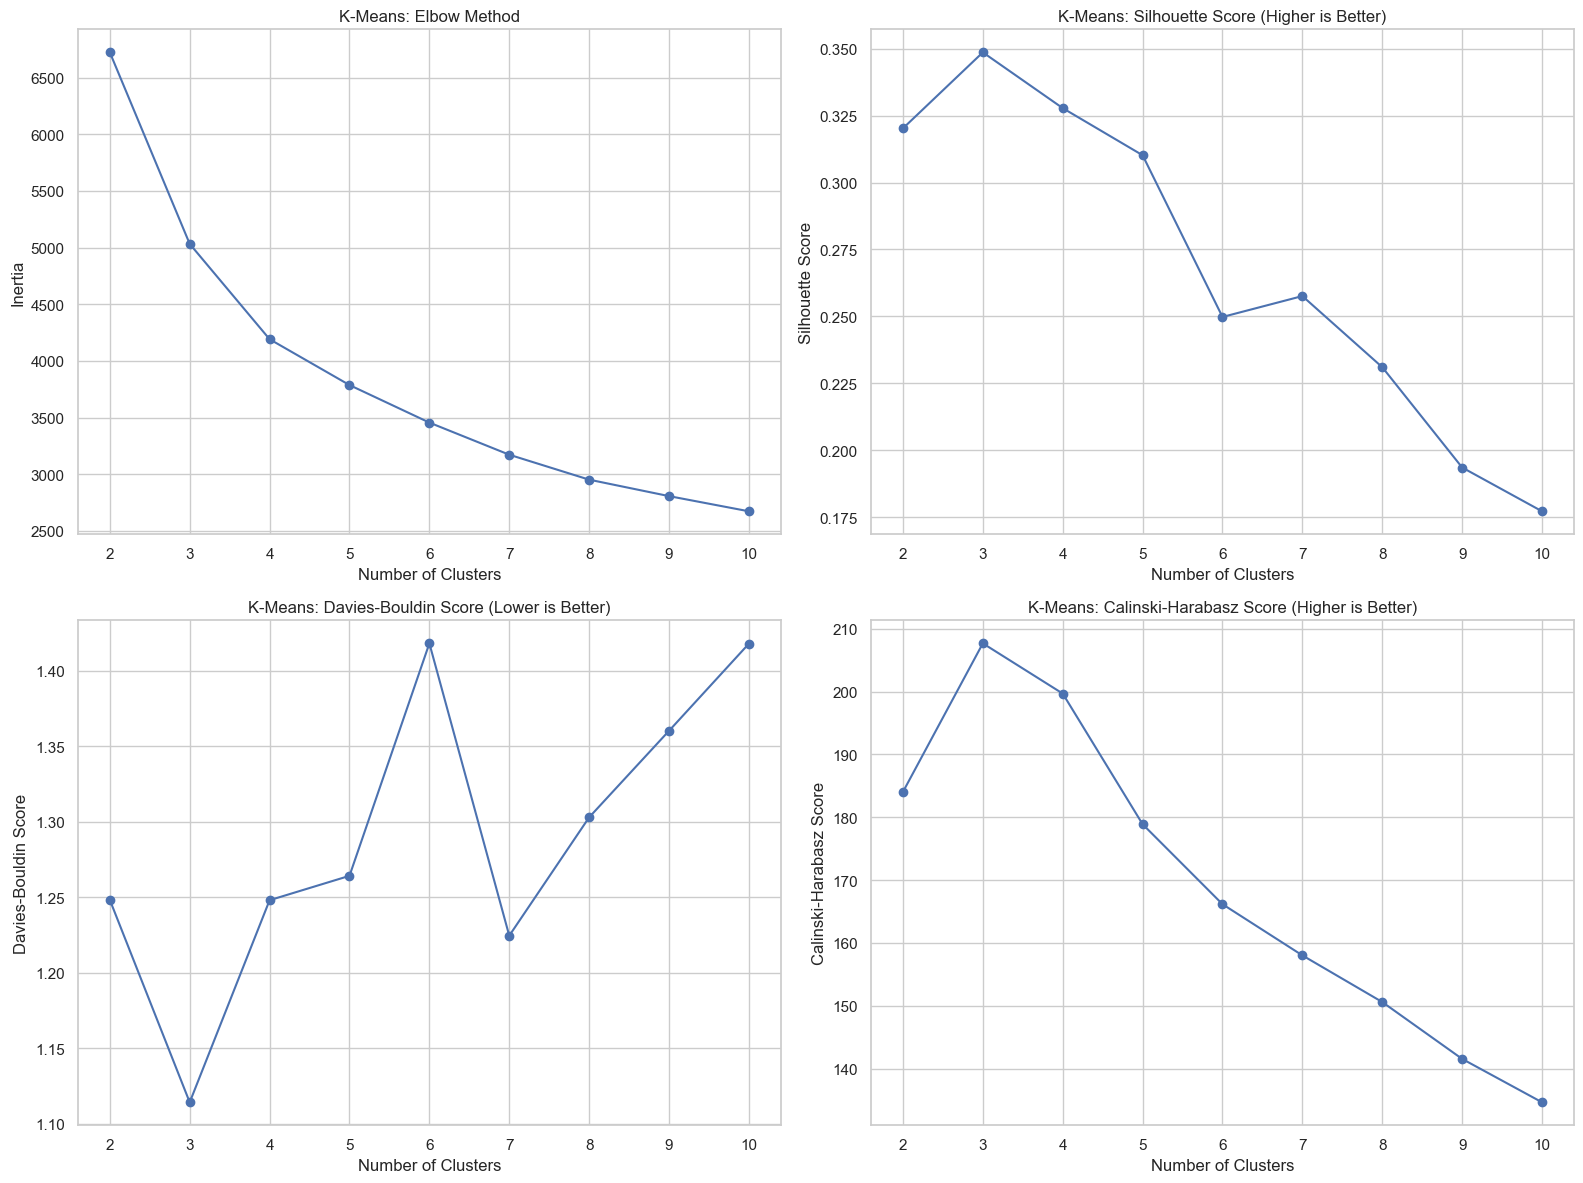

Optimal number of clusters based on silhouette score: 3
K-means model with 3 clusters saved to 'unsupervised_models/kmeans_model.pkl'


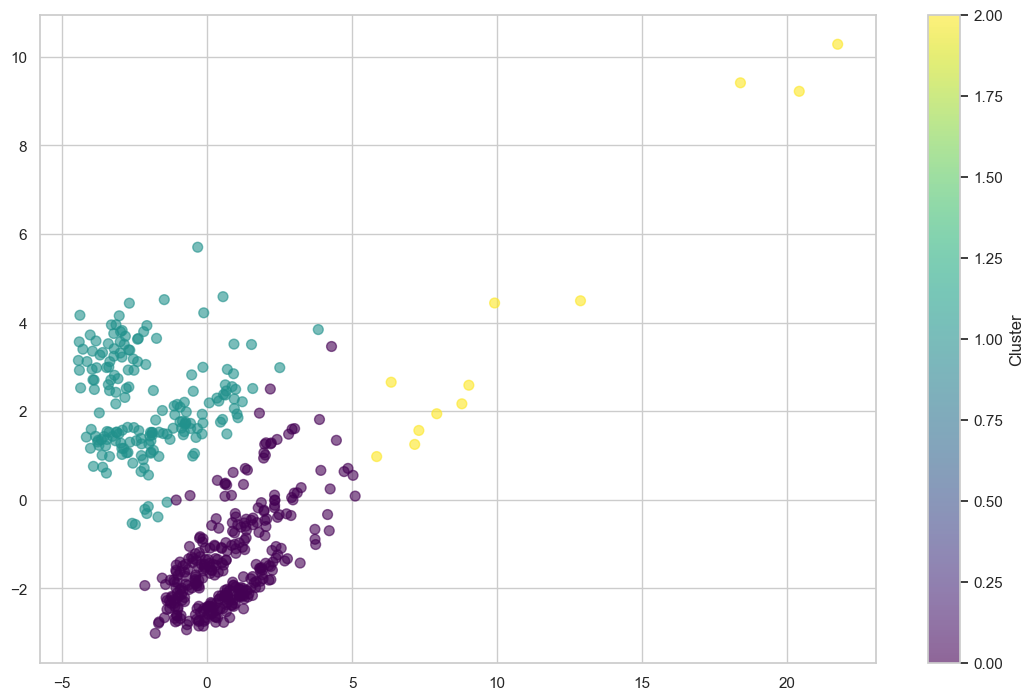

In [10]:


#####################################################
# Part 2: K-Means Clustering
#####################################################
print("\n========== K-Means Clustering ==========")

# Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    
    # Calculate Davies-Bouldin score (lower is better)
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    
    # Calculate Calinski-Harabasz score (higher is better)
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# Plot elbow curve
plt.figure(figsize=(16, 12))

# Inertia (Elbow Method)
plt.subplot(2, 2, 1)
plt.plot(range(2, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-Means: Elbow Method')
plt.grid(True)

# Silhouette Score
plt.subplot(2, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Silhouette Score (Higher is Better)')
plt.grid(True)

# Davies-Bouldin Score
plt.subplot(2, 2, 3)
plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('K-Means: Davies-Bouldin Score (Lower is Better)')
plt.grid(True)

# Calinski-Harabasz Score
plt.subplot(2, 2, 4)
plt.plot(range(2, max_clusters + 1), ch_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('K-Means: Calinski-Harabasz Score (Higher is Better)')
plt.grid(True)

plt.tight_layout()
plt.savefig('unsupervised_models/kmeans_cluster_evaluation.png')
plt.show()

# Determine optimal number of clusters based on metrics
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because we started at k=2
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
merged_df['cluster'] = cluster_labels

# Save the K-means model
joblib.dump(kmeans, 'unsupervised_models/kmeans_model.pkl')
print(f"K-means model with {optimal_k} clusters saved to 'unsupervised_models/kmeans_model.pkl'")

# Visualize clusters in PCA space
# Visualize clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')

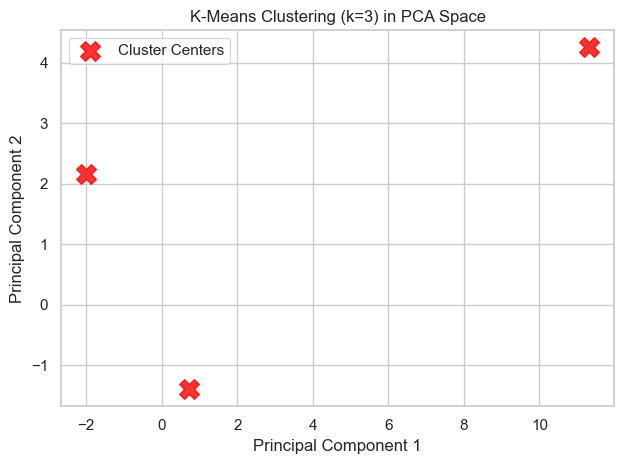


Cluster Statistics:
         monday_close  vix_close  range_pct  monday_volume  price_momentum  vix_momentum  count
cluster                                                                                        
0        10222.393987  16.996859   4.710449   5.570797e+05        0.837735      0.781925    316
1        19621.075691  15.548329   4.361443   6.980315e+07        0.829672      0.533448    181
2         9409.516667  44.513958  15.192573   0.000000e+00       -5.061525     54.990671     12


In [11]:
# Add cluster centers in PCA space
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, alpha=0.8, label='Cluster Centers')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-Means Clustering (k={optimal_k}) in PCA Space')
plt.legend()
plt.tight_layout()
plt.savefig('unsupervised_models/kmeans_clusters_pca.png')
plt.show()

# Analyze cluster characteristics
cluster_stats = merged_df.groupby('cluster').agg({
    'monday_close': 'mean',
    'vix_close': 'mean',
    'range_pct': 'mean',
    'monday_volume': 'mean',
    'price_momentum': 'mean',
    'vix_momentum': 'mean',
    'monday_date': 'count'
}).rename(columns={'monday_date': 'count'})

print("\nCluster Statistics:")
print(cluster_stats)

In [12]:
# Calculate additional metrics for each cluster
cluster_stats['avg_high_range_pct'] = merged_df.groupby('cluster')['high_range_pct'].mean()
cluster_stats['avg_low_range_pct'] = merged_df.groupby('cluster')['low_range_pct'].mean()
cluster_stats['avg_price_vix_ratio'] = merged_df.groupby('cluster')['price_vix_ratio'].mean()

# Save cluster statistics
cluster_stats.to_csv('unsupervised_models/cluster_statistics.csv')
print("Cluster statistics saved to 'unsupervised_models/cluster_statistics.csv'")

Cluster statistics saved to 'unsupervised_models/cluster_statistics.csv'


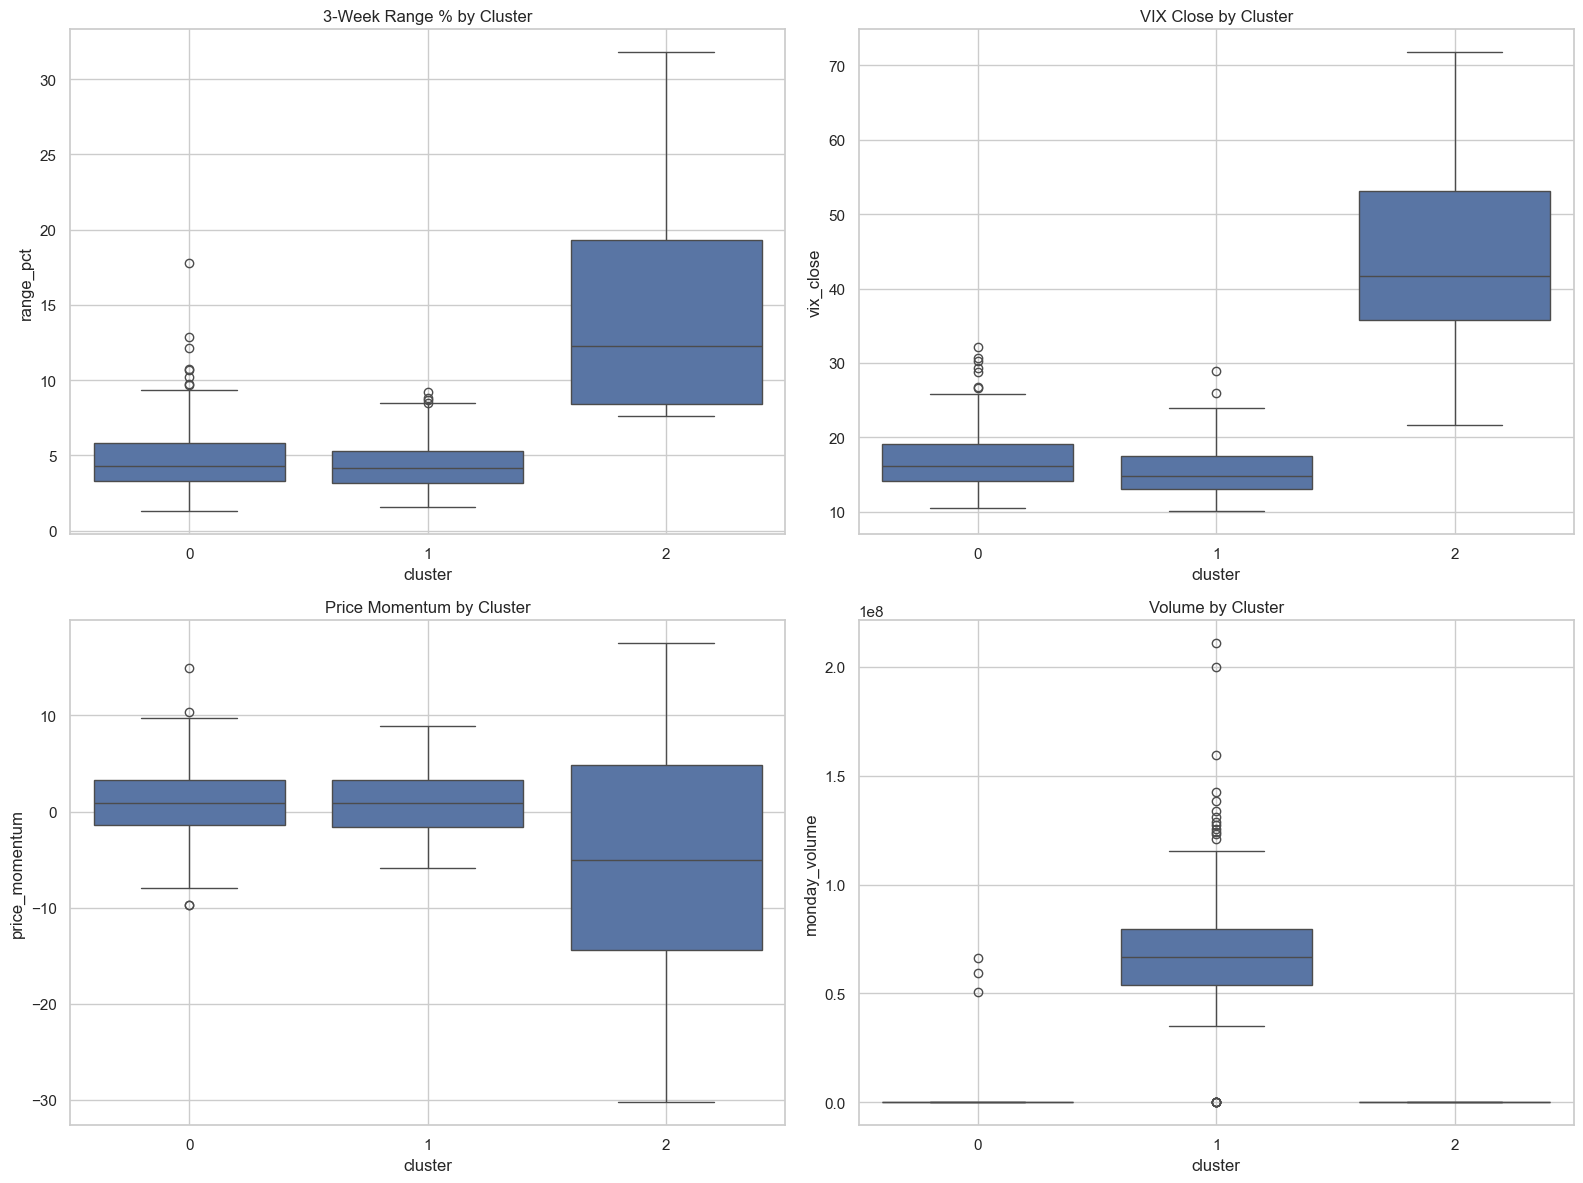

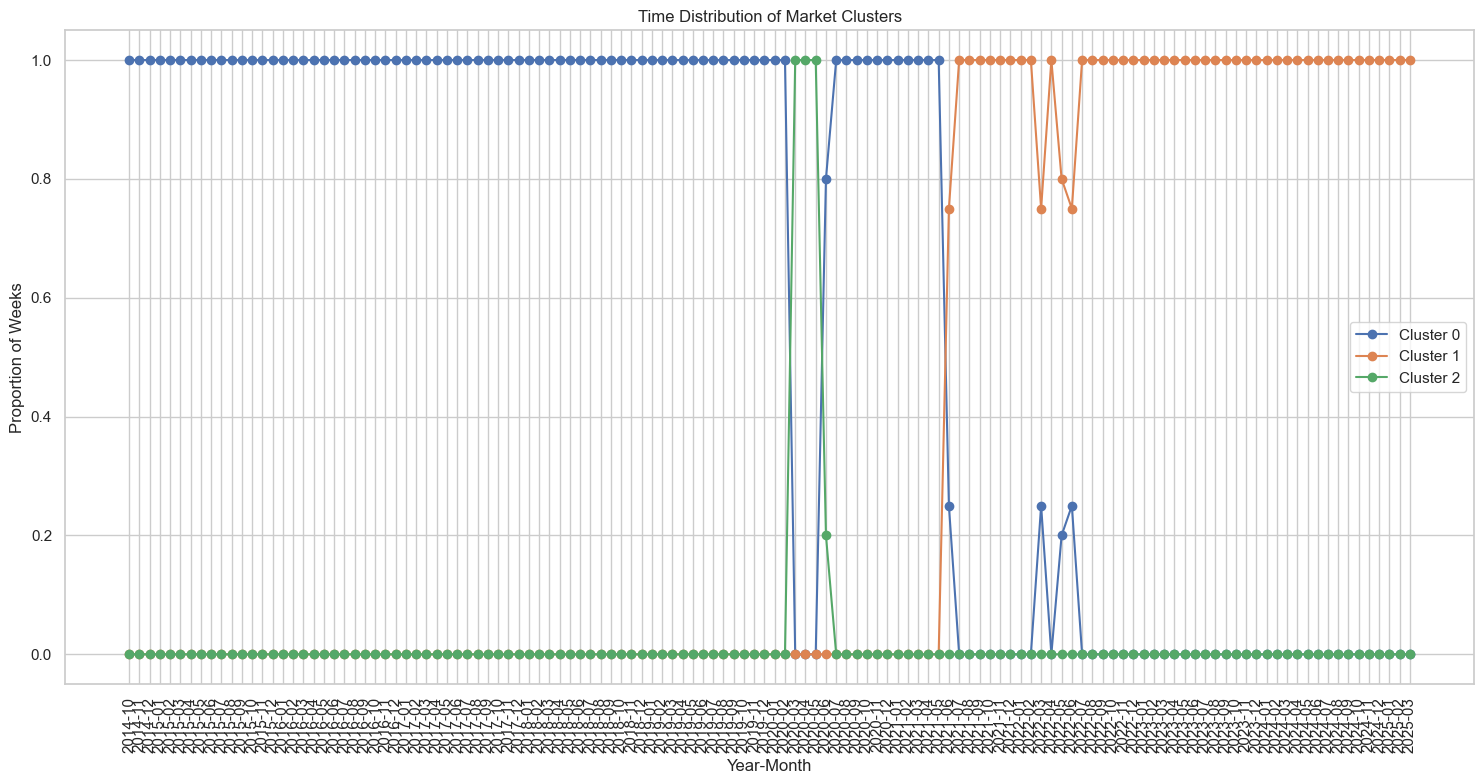

In [13]:


# Visualize cluster characteristics
plt.figure(figsize=(16, 12))

# Range percentage by cluster
plt.subplot(2, 2, 1)
sns.boxplot(x='cluster', y='range_pct', data=merged_df)
plt.title('3-Week Range % by Cluster')
plt.grid(True)

# VIX close by cluster
plt.subplot(2, 2, 2)
sns.boxplot(x='cluster', y='vix_close', data=merged_df)
plt.title('VIX Close by Cluster')
plt.grid(True)

# Price momentum by cluster
plt.subplot(2, 2, 3)
sns.boxplot(x='cluster', y='price_momentum', data=merged_df)
plt.title('Price Momentum by Cluster')
plt.grid(True)

# Volume by cluster
plt.subplot(2, 2, 4)
sns.boxplot(x='cluster', y='monday_volume', data=merged_df)
plt.title('Volume by Cluster')
plt.grid(True)

plt.tight_layout()
plt.savefig('unsupervised_models/cluster_characteristics.png')
plt.show()

# Analyze time distribution of clusters
merged_df['year_month'] = merged_df['monday_date'].dt.to_period('M')
cluster_time_dist = pd.crosstab(
    merged_df['year_month'], 
    merged_df['cluster'], 
    normalize='index'
).reset_index()
cluster_time_dist['year_month'] = cluster_time_dist['year_month'].astype(str)

# Plot time distribution of clusters
plt.figure(figsize=(15, 8))
for i in range(optimal_k):
    plt.plot(cluster_time_dist['year_month'], cluster_time_dist[i], 
             marker='o', label=f'Cluster {i}')

plt.xlabel('Year-Month')
plt.ylabel('Proportion of Weeks')
plt.title('Time Distribution of Market Clusters')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('unsupervised_models/cluster_time_distribution.png')
plt.show()

In [14]:
# Analyze subsequent market performance by cluster
merged_df['next_week_close'] = merged_df['monday_close'].shift(-1)
merged_df['next_week_return'] = (merged_df['next_week_close'] - merged_df['monday_close']) / merged_df['monday_close'] * 100

performance_by_cluster = merged_df.groupby('cluster').agg({
    'next_week_return': ['mean', 'std', 'min', 'max', 'count']
})

print("\nSubsequent Week Performance by Cluster:")
print(performance_by_cluster)

# Save performance analysis
performance_by_cluster.to_csv('unsupervised_models/cluster_performance.csv')
print("Cluster performance analysis saved to 'unsupervised_models/cluster_performance.csv'")

# Provide market regime interpretation
print("\nMarket Regime Interpretation by Cluster:")
for i in range(optimal_k):
    cluster_data = merged_df[merged_df['cluster'] == i]
    avg_range = cluster_data['range_pct'].mean()
    avg_vix = cluster_data['vix_close'].mean()
    avg_return = cluster_data['next_week_return'].mean()
    
    print(f"\nCluster {i}:")
    print(f"  Average Range: {avg_range:.2f}%")
    print(f"  Average VIX: {avg_vix:.2f}")
    print(f"  Average Next Week Return: {avg_return:.2f}%")
    
    # Determine market regime characteristics
    if avg_vix > merged_df['vix_close'].mean():
        vix_status = "High VIX"
    else:
        vix_status = "Low VIX"
        
    if avg_range > merged_df['range_pct'].mean():
        range_status = "High Range"
    else:
        range_status = "Low Range"
    
    print(f"  Market Regime: {vix_status}, {range_status}")


Subsequent Week Performance by Cluster:
        next_week_return                                      
                    mean       std        min        max count
cluster                                                       
0               0.317882  2.197045  -5.779052   9.868586   316
1               0.134337  2.027135  -5.766753   5.979877   180
2              -0.508008  7.812496 -16.923772  10.014822    12
Cluster performance analysis saved to 'unsupervised_models/cluster_performance.csv'

Market Regime Interpretation by Cluster:

Cluster 0:
  Average Range: 4.71%
  Average VIX: 17.00
  Average Next Week Return: 0.32%
  Market Regime: Low VIX, Low Range

Cluster 1:
  Average Range: 4.36%
  Average VIX: 15.55
  Average Next Week Return: 0.13%
  Market Regime: Low VIX, Low Range

Cluster 2:
  Average Range: 15.19%
  Average VIX: 44.51
  Average Next Week Return: -0.51%
  Market Regime: High VIX, High Range



========== Gaussian Mixture Model ==========


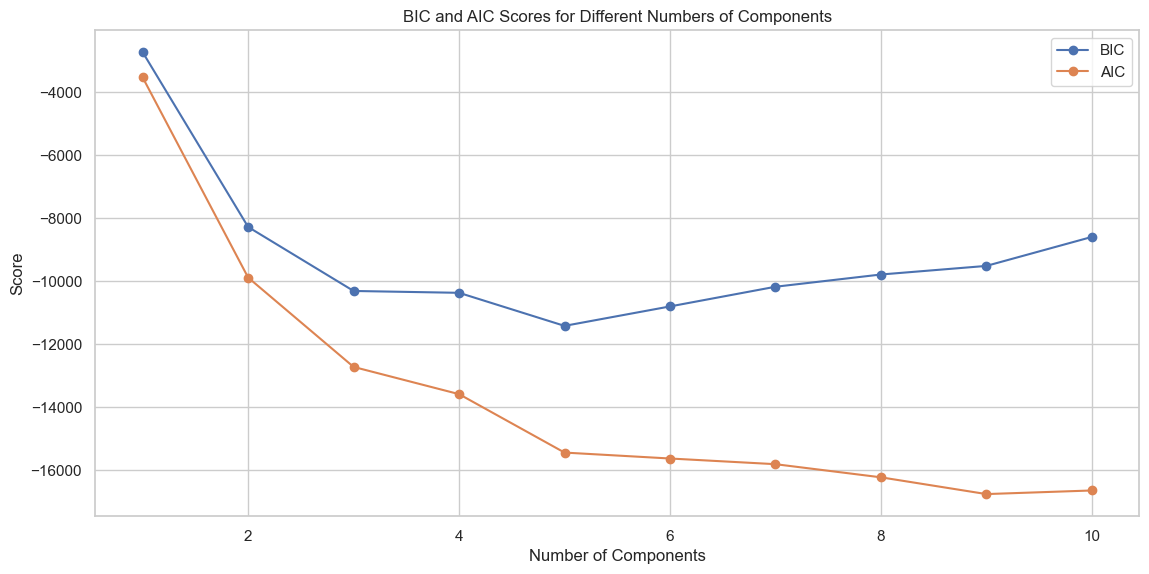

Optimal number of components based on BIC: 5
GMM model with 5 components saved to 'unsupervised_models/gmm_model.pkl'


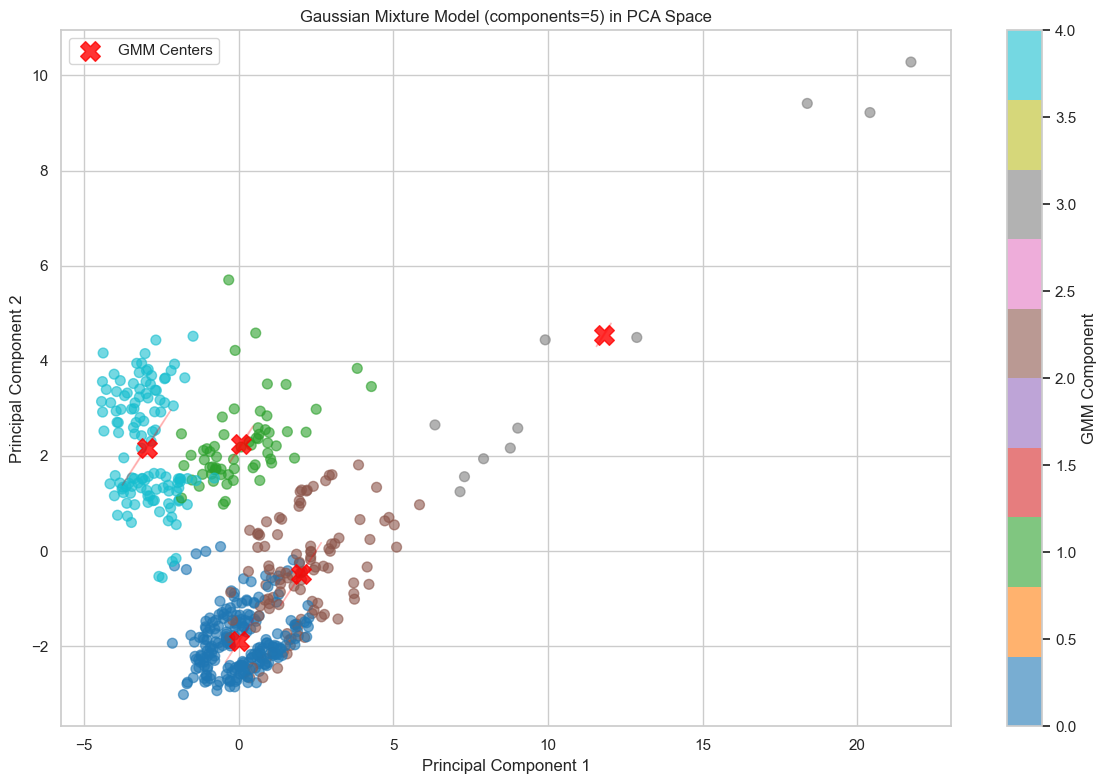

In [15]:
#####################################################
# Part 3: Gaussian Mixture Model (GMM)
#####################################################
print("\n========== Gaussian Mixture Model ==========")

# Determine optimal number of components using BIC
bic_scores = []
aic_scores = []
max_components = 10

for n in range(1, max_components + 1):
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=10)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

# Plot BIC and AIC scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_components + 1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, max_components + 1), aic_scores, marker='o', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for Different Numbers of Components')
plt.legend()
plt.grid(True)
plt.savefig('unsupervised_models/gmm_bic_aic.png')
plt.show()

# Determine optimal number of components based on BIC
optimal_components = bic_scores.index(min(bic_scores)) + 1
print(f"Optimal number of components based on BIC: {optimal_components}")

# Apply GMM with optimal components
gmm = GaussianMixture(n_components=optimal_components, random_state=42, n_init=10)
gmm_labels = gmm.fit_predict(X_scaled)

# Add GMM labels to original dataframe
merged_df['gmm_cluster'] = gmm_labels

# Save the GMM model
joblib.dump(gmm, 'unsupervised_models/gmm_model.pkl')
print(f"GMM model with {optimal_components} components saved to 'unsupervised_models/gmm_model.pkl'")

# Visualize GMM clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='GMM Component')

# Calculate GMM centers in PCA space
centers = gmm.means_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, alpha=0.8, label='GMM Centers')

# Plot GMM covariance ellipses
from matplotlib.patches import Ellipse

for i in range(optimal_components):
    covariance = gmm.covariances_[i][:2, :2]
    v, w = np.linalg.eigh(covariance)
    angle = np.arctan2(w[0][1], w[0][0]) * 180 / np.pi
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(
        xy=(centers_pca[i, 0], centers_pca[i, 1]),
        width=v[0], height=v[1],
        angle=angle, color='red', alpha=0.2
    )
    plt.gca().add_patch(ellipse)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Gaussian Mixture Model (components={optimal_components}) in PCA Space')
plt.legend()
plt.tight_layout()
plt.savefig('unsupervised_models/gmm_clusters_pca.png')
plt.show()


GMM Cluster Statistics:
             monday_close  vix_close  range_pct  monday_volume  price_momentum  vix_momentum  count
gmm_cluster                                                                                        
0             9856.451651  14.841274   4.191292   0.000000e+00        0.876964     -1.278286    212
1            17425.851613  19.788750   5.819376   8.305983e+07        0.081592      5.732251     62
2            10960.240952  21.164857   5.639271   0.000000e+00        1.105231      3.476578    105
3             9370.881818  45.838864  15.848856   0.000000e+00       -5.965408     62.786055     11
4            20762.435714  13.610357   3.734601   6.437561e+07        0.947494     -1.147561    119
GMM cluster statistics saved to 'unsupervised_models/gmm_cluster_statistics.csv'


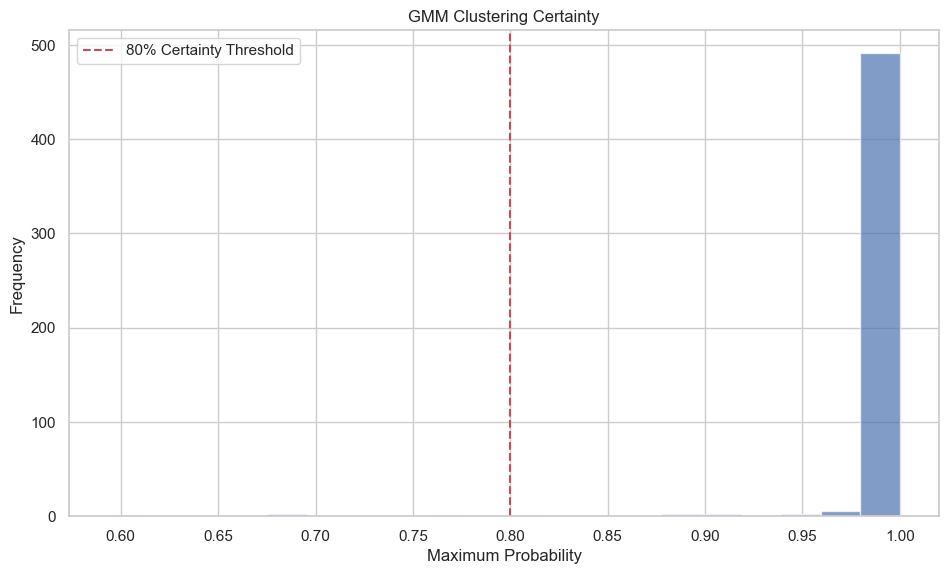


Number of uncertain cluster assignments: 4 (0.79%)


In [16]:
# Analyze GMM cluster characteristics
gmm_cluster_stats = merged_df.groupby('gmm_cluster').agg({
    'monday_close': 'mean',
    'vix_close': 'mean',
    'range_pct': 'mean',
    'monday_volume': 'mean',
    'price_momentum': 'mean',
    'vix_momentum': 'mean',
    'monday_date': 'count'
}).rename(columns={'monday_date': 'count'})

print("\nGMM Cluster Statistics:")
print(gmm_cluster_stats)

# Calculate additional metrics for each GMM cluster
gmm_cluster_stats['avg_high_range_pct'] = merged_df.groupby('gmm_cluster')['high_range_pct'].mean()
gmm_cluster_stats['avg_low_range_pct'] = merged_df.groupby('gmm_cluster')['low_range_pct'].mean()
gmm_cluster_stats['avg_price_vix_ratio'] = merged_df.groupby('gmm_cluster')['price_vix_ratio'].mean()

# Save GMM cluster statistics
gmm_cluster_stats.to_csv('unsupervised_models/gmm_cluster_statistics.csv')
print("GMM cluster statistics saved to 'unsupervised_models/gmm_cluster_statistics.csv'")

# Calculate probability of each data point belonging to each cluster
gmm_probs = gmm.predict_proba(X_scaled)

# Add uncertainty measure (max probability) to dataframe
merged_df['gmm_max_prob'] = np.max(gmm_probs, axis=1)

# Visualize probability certainty
plt.figure(figsize=(10, 6))
plt.hist(merged_df['gmm_max_prob'], bins=20, alpha=0.7)
plt.axvline(0.8, color='r', linestyle='--', label='80% Certainty Threshold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.title('GMM Clustering Certainty')
plt.legend()
plt.grid(True)
plt.savefig('unsupervised_models/gmm_certainty_histogram.png')
plt.show()

# Analyze uncertain points (less than 80% certainty)
uncertain_points = merged_df[merged_df['gmm_max_prob'] < 0.8]
print(f"\nNumber of uncertain cluster assignments: {len(uncertain_points)} ({len(uncertain_points)/len(merged_df)*100:.2f}%)")

# Analyze next week performance based on GMM cluster
next_week_perf_by_gmm = merged_df.groupby('gmm_cluster').agg({
    'next_week_return': ['mean', 'std', 'min', 'max', 'count']
})

In [17]:
print("\nSubsequent Week Performance by GMM Cluster:")
print(next_week_perf_by_gmm)

# Save GMM performance analysis
next_week_perf_by_gmm.to_csv('unsupervised_models/gmm_cluster_performance.csv')
print("GMM cluster performance analysis saved to 'unsupervised_models/gmm_cluster_performance.csv'")


Subsequent Week Performance by GMM Cluster:
            next_week_return                                      
                        mean       std        min        max count
gmm_cluster                                                       
0                   0.067726  1.955989  -5.779052   5.484836   212
1                   0.238104  2.705318  -5.766753   5.979877    62
2                   0.741168  2.512880  -5.234610   9.868586   105
3                  -0.973216  8.017598 -16.923772  10.014822    11
4                   0.188964  1.693855  -3.867644   4.214600   118
GMM cluster performance analysis saved to 'unsupervised_models/gmm_cluster_performance.csv'



========== DBSCAN Clustering ==========


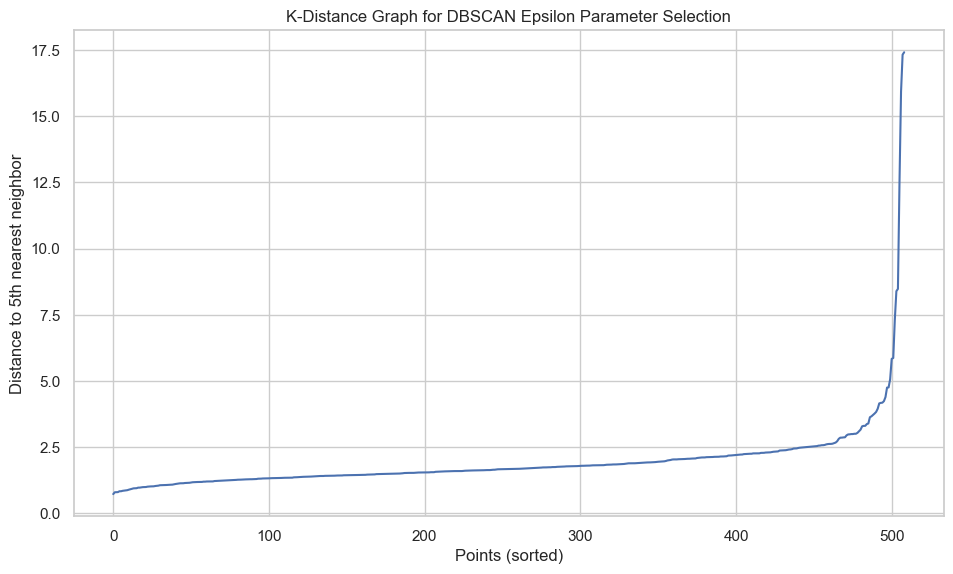

Optimal epsilon from k-distance graph: 4.1780
DBSCAN model with eps=4.1780 saved to 'unsupervised_models/dbscan_model.pkl'
Number of clusters: 1
Number of noise points: 9 (1.77%)


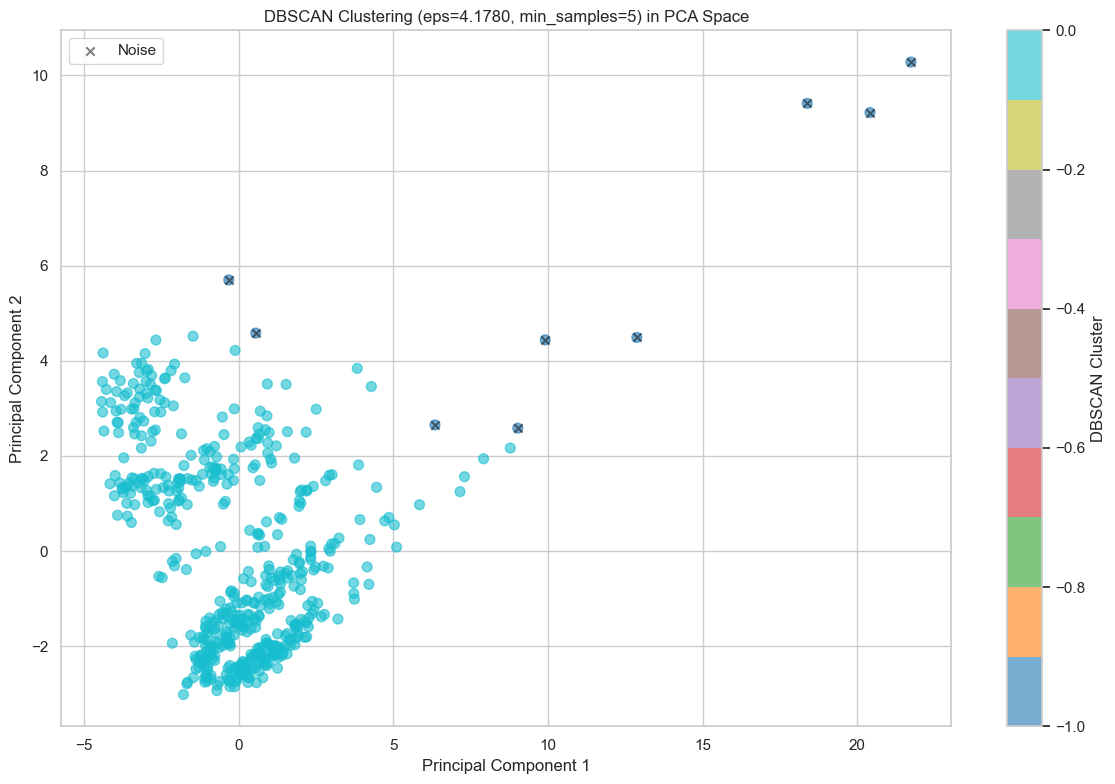


Outlier vs Non-Outlier Statistics:
                         Outliers  Non-Outliers  Difference %
monday_close         1.242665e+04  1.356553e+04     -8.395404
monday_open          1.252828e+04  1.357963e+04     -7.742056
monday_high          1.256941e+04  1.360828e+04     -7.634084
monday_low           1.235883e+04  1.352267e+04     -8.606543
monday_volume        2.980137e+07  2.508439e+07     18.804447
vix_open             4.132333e+01  1.617692e+01    155.446237
vix_high             4.447750e+01  1.704468e+01    160.946448
vix_low              3.761500e+01  1.503313e+01    150.214111
vix_close            4.266583e+01  1.667086e+01    155.930608
monday_range         2.028179e+00  6.330178e-01    220.398454
vix_range            1.968919e+01  1.200567e+01     63.999144
range_pct            1.734721e+01  4.608218e+00    276.440764
prev_week_range      1.703556e+01  4.610243e+00    269.515421
prev_week_vix_close  3.842750e+01  1.674629e+01    129.468668
vix_week_change      1.959336e+01 

In [18]:
#####################################################
# Part 4: DBSCAN Clustering for Outlier Detection
#####################################################
print("\n========== DBSCAN Clustering ==========")

# Determine optimal epsilon using k-nearest neighbors distance
from sklearn.neighbors import NearestNeighbors

# Use k=5 as a reasonable starting point for high-dimensional data
k = 5
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)

# Sort distances in ascending order
distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points (sorted)')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.title('K-Distance Graph for DBSCAN Epsilon Parameter Selection')
plt.grid(True)
plt.savefig('unsupervised_models/dbscan_kdistance.png')
plt.show()

# Find elbow point in k-distance graph
from kneed import KneeLocator
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
optimal_eps = distances[kneedle.knee]
print(f"Optimal epsilon from k-distance graph: {optimal_eps:.4f}")

# Apply DBSCAN with optimal parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=k)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to original dataframe
merged_df['dbscan_cluster'] = dbscan_labels

# Save the DBSCAN model
joblib.dump(dbscan, 'unsupervised_models/dbscan_model.pkl')
print(f"DBSCAN model with eps={optimal_eps:.4f} saved to 'unsupervised_models/dbscan_model.pkl'")

# Count number of clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(X_scaled)*100:.2f}%)")

# Visualize DBSCAN clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='DBSCAN Cluster')
plt.scatter(X_pca[dbscan_labels == -1, 0], X_pca[dbscan_labels == -1, 1], 
            c='black', marker='x', label='Noise', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'DBSCAN Clustering (eps={optimal_eps:.4f}, min_samples={k}) in PCA Space')
plt.legend()
plt.tight_layout()
plt.savefig('unsupervised_models/dbscan_clusters_pca.png')
plt.show()

# Analyze outlier characteristics
outliers = merged_df[merged_df['dbscan_cluster'] == -1]
non_outliers = merged_df[merged_df['dbscan_cluster'] != -1]

print("\nOutlier vs Non-Outlier Statistics:")
print(pd.DataFrame({
    'Outliers': outliers[features].mean(),
    'Non-Outliers': non_outliers[features].mean(),
    'Difference %': (outliers[features].mean() - non_outliers[features].mean()) / non_outliers[features].mean() * 100
}))

# Save outlier analysis
outlier_analysis = pd.DataFrame({
    'Outliers': outliers[features].mean(),
    'Non-Outliers': non_outliers[features].mean(),
    'Difference %': (outliers[features].mean() - non_outliers[features].mean()) / non_outliers[features].mean() * 100
})
outlier_analysis.to_csv('unsupervised_models/dbscan_outlier_analysis.csv')
print("DBSCAN outlier analysis saved to 'unsupervised_models/dbscan_outlier_analysis.csv'")

# Analyze subsequent market performance for outliers vs non-outliers
outlier_performance = {
    'Outliers': {
        'mean': outliers['next_week_return'].mean(),
        'std': outliers['next_week_return'].std(),
        'count': len(outliers)
    },
    'Non-Outliers': {
        'mean': non_outliers['next_week_return'].mean(),
        'std': non_outliers['next_week_return'].std(),
        'count': len(non_outliers)
    }
}

In [19]:
print("\nSubsequent Week Performance (Outliers vs Non-Outliers):")
print(pd.DataFrame(outlier_performance))

# Save outlier performance analysis
pd.DataFrame(outlier_performance).to_csv('unsupervised_models/dbscan_outlier_performance.csv')
print("DBSCAN outlier performance analysis saved to 'unsupervised_models/dbscan_outlier_performance.csv'")


Subsequent Week Performance (Outliers vs Non-Outliers):
       Outliers  Non-Outliers
mean  -0.604184      0.248443
std    8.862309      2.150614
count  9.000000    500.000000
DBSCAN outlier performance analysis saved to 'unsupervised_models/dbscan_outlier_performance.csv'



========== Isolation Forest Anomaly Detection ==========
Isolation Forest model saved to 'unsupervised_models/isolation_forest_model.pkl'
Number of anomalies detected: 26 (5.11%)


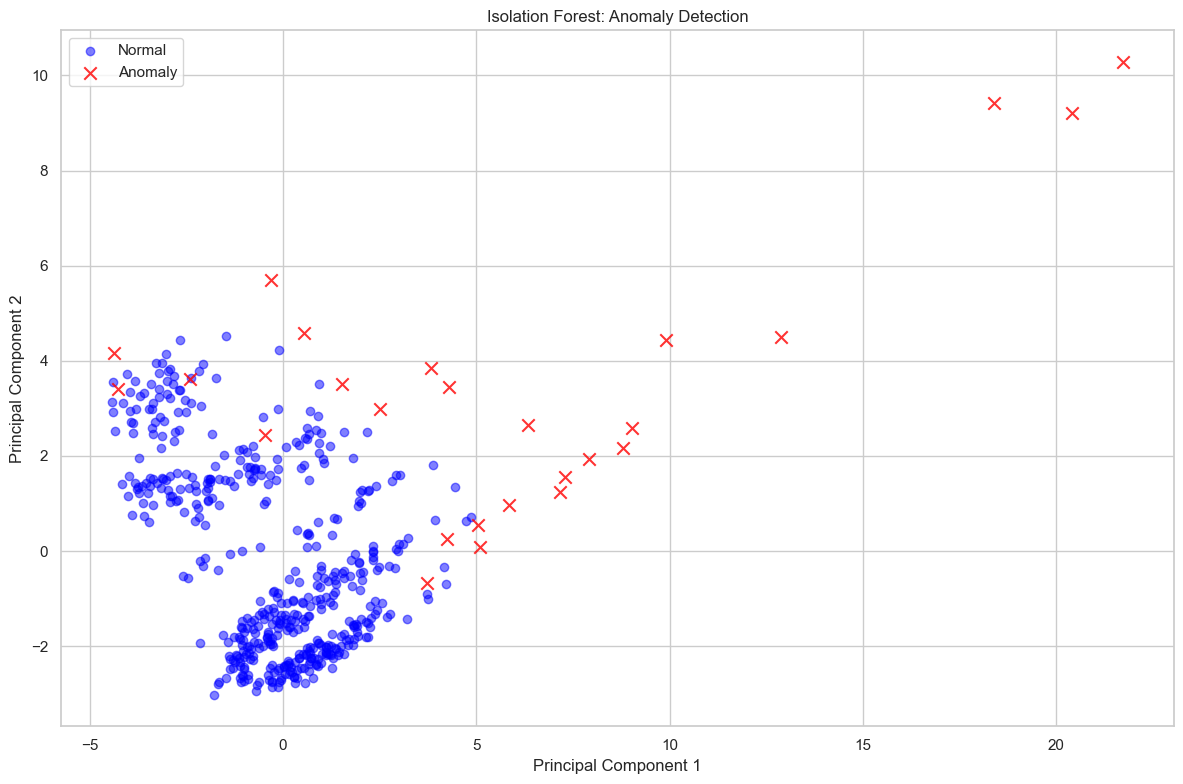


Anomaly vs Normal Statistics:
                        Anomalies        Normal  Difference %
monday_close         1.360247e+04  1.354232e+04      0.444163
monday_open          1.364070e+04  1.355675e+04      0.619266
monday_high          1.369293e+04  1.358436e+04      0.799205
monday_low           1.352750e+04  1.350072e+04      0.198351
monday_volume        3.599179e+07  2.458514e+07     46.396564
vix_open             3.153654e+01  1.581867e+01     99.362706
vix_high             3.394750e+01  1.664597e+01    103.938213
vix_low              2.960625e+01  1.466943e+01    101.822761
vix_close            3.274769e+01  1.628982e+01    101.031654
monday_range         1.403859e+00  6.175201e-01    127.338137
vix_range            1.393606e+01  1.204493e+01     15.700696
range_pct            1.064680e+01  4.520532e+00    135.520973
prev_week_range      1.144231e+01  4.473999e+00    155.751306
prev_week_vix_close  3.198654e+01  1.632991e+01     95.877042
vix_week_change      6.174253e+00  2.73

In [20]:
#####################################################
# Part 5: Isolation Forest for Anomaly Detection
#####################################################
print("\n========== Isolation Forest Anomaly Detection ==========")

# Apply Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest_scores = iso_forest.fit_predict(X_scaled)
anomaly_scores = iso_forest.decision_function(X_scaled)

# Convert scores to anomaly probabilities (lower score = more anomalous)
# Normalize scores to [0,1] range where 0 is most anomalous
normalized_scores = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))

# Add scores to dataframe
merged_df['iso_forest_anomaly'] = iso_forest_scores
merged_df['iso_forest_score'] = normalized_scores

# Save the Isolation Forest model
joblib.dump(iso_forest, 'unsupervised_models/isolation_forest_model.pkl')
print("Isolation Forest model saved to 'unsupervised_models/isolation_forest_model.pkl'")

# Identify anomalies
anomalies = merged_df[merged_df['iso_forest_anomaly'] == -1]
normal = merged_df[merged_df['iso_forest_anomaly'] == 1]
print(f"Number of anomalies detected: {len(anomalies)} ({len(anomalies)/len(merged_df)*100:.2f}%)")

# Visualize anomalies in PCA space
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[merged_df['iso_forest_anomaly'] == 1, 0], X_pca[merged_df['iso_forest_anomaly'] == 1, 1], 
            c='blue', label='Normal', alpha=0.5)
plt.scatter(X_pca[merged_df['iso_forest_anomaly'] == -1, 0], X_pca[merged_df['iso_forest_anomaly'] == -1, 1], 
            c='red', marker='x', label='Anomaly', alpha=0.8, s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Isolation Forest: Anomaly Detection')
plt.legend()
plt.tight_layout()
plt.savefig('unsupervised_models/isolation_forest_anomalies.png')
plt.show()

# Analyze anomaly characteristics
print("\nAnomaly vs Normal Statistics:")
print(pd.DataFrame({
    'Anomalies': anomalies[features].mean(),
    'Normal': normal[features].mean(),
    'Difference %': (anomalies[features].mean() - normal[features].mean()) / normal[features].mean() * 100
}))

In [21]:
# Save anomaly analysis
anomaly_analysis = pd.DataFrame({
    'Anomalies': anomalies[features].mean(),
    'Normal': normal[features].mean(),
    'Difference %': (anomalies[features].mean() - normal[features].mean()) / normal[features].mean() * 100
})
anomaly_analysis.to_csv('unsupervised_models/isolation_forest_anomaly_analysis.csv')
print("Isolation Forest anomaly analysis saved to 'unsupervised_models/isolation_forest_anomaly_analysis.csv'")

Isolation Forest anomaly analysis saved to 'unsupervised_models/isolation_forest_anomaly_analysis.csv'


In [22]:


# Analyze subsequent market performance for anomalies vs normal
anomaly_performance = {
    'Anomalies': {
        'mean': anomalies['next_week_return'].mean(),
        'std': anomalies['next_week_return'].std(),
        'count': len(anomalies)
    },
    'Normal': {
        'mean': normal['next_week_return'].mean(),
        'std': normal['next_week_return'].std(),
        'count': len(normal)
    }
}

print("\nSubsequent Week Performance (Anomalies vs Normal):")
print(pd.DataFrame(anomaly_performance))

# Save anomaly performance analysis
pd.DataFrame(anomaly_performance).to_csv('unsupervised_models/isolation_forest_anomaly_performance.csv')
print("Isolation Forest anomaly performance analysis saved to 'unsupervised_models/isolation_forest_anomaly_performance.csv'")


Subsequent Week Performance (Anomalies vs Normal):
       Anomalies      Normal
mean    0.086686    0.241248
std     5.686584    2.103878
count  26.000000  483.000000
Isolation Forest anomaly performance analysis saved to 'unsupervised_models/isolation_forest_anomaly_performance.csv'



========== Local Outlier Factor (LOF) ==========
Number of LOF anomalies detected: 26 (5.11%)


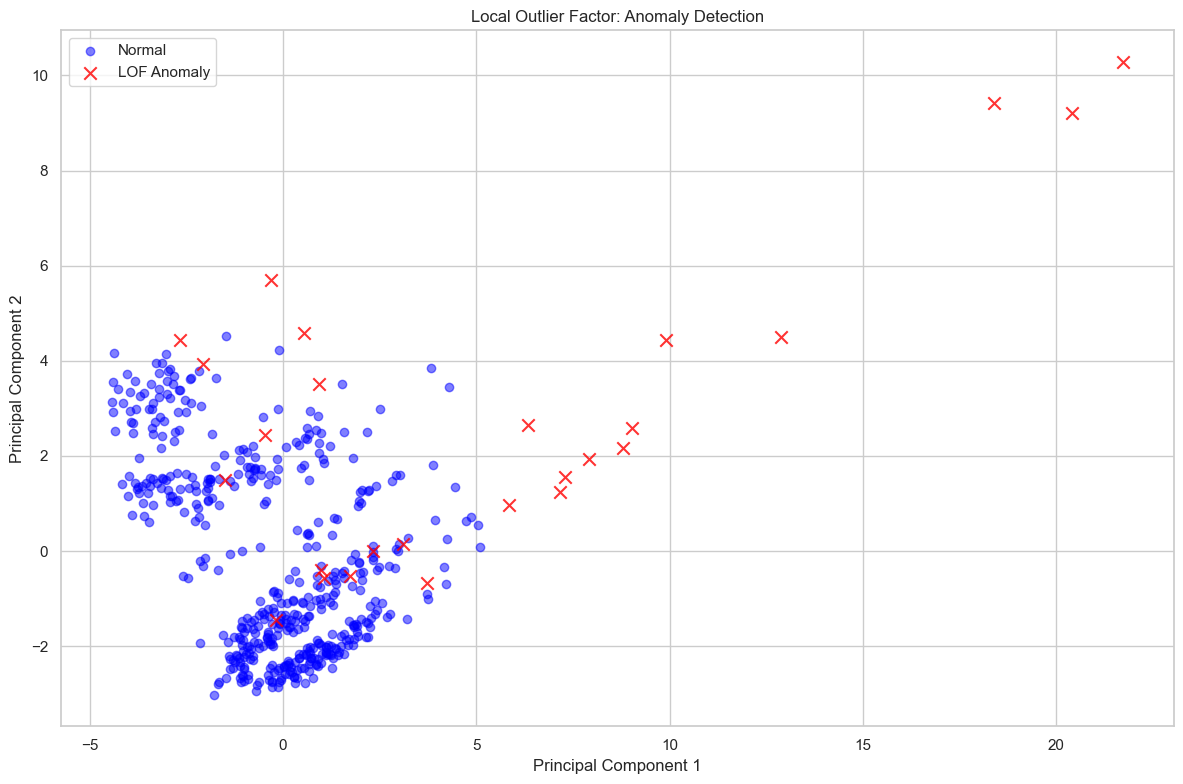


LOF Anomaly vs Normal Statistics:
                     LOF Anomalies        Normal  Difference %
monday_close          1.284680e+04  1.358300e+04     -5.420005
monday_open           1.287741e+04  1.359784e+04     -5.298080
monday_high           1.293716e+04  1.362505e+04     -5.048669
monday_low            1.276138e+04  1.354196e+04     -5.764193
monday_volume         3.553065e+07  2.460996e+07     44.375102
vix_open              2.942250e+01  1.593247e+01     84.670000
vix_high              3.194337e+01  1.675386e+01     90.662766
vix_low               2.671327e+01  1.482516e+01     80.188736
vix_close             3.051106e+01  1.641022e+01     85.927200
monday_range          1.549935e+00  6.096567e-01    154.230828
vix_range             2.007532e+01  1.171445e+01     71.372275
range_pct             1.012951e+01  4.548378e+00    122.705969
prev_week_range       1.060897e+01  4.518857e+00    134.771110
prev_week_vix_close   2.983404e+01  1.644578e+01     81.408513
vix_week_change     

In [23]:
#####################################################
# Part 6: Local Outlier Factor (LOF)
#####################################################
print("\n========== Local Outlier Factor (LOF) ==========")

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_labels = lof.fit_predict(X_scaled)
lof_scores = lof.negative_outlier_factor_

# Add LOF results to dataframe
merged_df['lof_anomaly'] = lof_labels
merged_df['lof_score'] = lof_scores

# Identify LOF anomalies
lof_anomalies = merged_df[merged_df['lof_anomaly'] == -1]
lof_normal = merged_df[merged_df['lof_anomaly'] == 1]
print(f"Number of LOF anomalies detected: {len(lof_anomalies)} ({len(lof_anomalies)/len(merged_df)*100:.2f}%)")

# Visualize LOF anomalies in PCA space
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[merged_df['lof_anomaly'] == 1, 0], X_pca[merged_df['lof_anomaly'] == 1, 1], 
            c='blue', label='Normal', alpha=0.5)
plt.scatter(X_pca[merged_df['lof_anomaly'] == -1, 0], X_pca[merged_df['lof_anomaly'] == -1, 1], 
            c='red', marker='x', label='LOF Anomaly', alpha=0.8, s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Local Outlier Factor: Anomaly Detection')
plt.legend()
plt.tight_layout()
plt.savefig('unsupervised_models/lof_anomalies.png')
plt.show()

# Analyze LOF anomaly characteristics
print("\nLOF Anomaly vs Normal Statistics:")
print(pd.DataFrame({
    'LOF Anomalies': lof_anomalies[features].mean(),
    'Normal': lof_normal[features].mean(),
    'Difference %': (lof_anomalies[features].mean() - lof_normal[features].mean()) / lof_normal[features].mean() * 100
}))

In [24]:
# Save LOF anomaly analysis
lof_anomaly_analysis = pd.DataFrame({
    'LOF Anomalies': lof_anomalies[features].mean(),
    'Normal': lof_normal[features].mean(),
    'Difference %': (lof_anomalies[features].mean() - lof_normal[features].mean()) / lof_normal[features].mean() * 100
})
lof_anomaly_analysis.to_csv('unsupervised_models/lof_anomaly_analysis.csv')
print("LOF anomaly analysis saved to 'unsupervised_models/lof_anomaly_analysis.csv'")

LOF anomaly analysis saved to 'unsupervised_models/lof_anomaly_analysis.csv'


In [25]:
# Analyze subsequent market performance for LOF anomalies vs normal
lof_performance = {
    'LOF Anomalies': {
        'mean': lof_anomalies['next_week_return'].mean(),
        'std': lof_anomalies['next_week_return'].std(),
        'count': len(lof_anomalies)
    },
    'Normal': {
        'mean': lof_normal['next_week_return'].mean(),
        'std': lof_normal['next_week_return'].std(),
        'count': len(lof_normal)
    }
}

print("\nSubsequent Week Performance (LOF Anomalies vs Normal):")
print(pd.DataFrame(lof_performance))

# Save LOF anomaly performance analysis
pd.DataFrame(lof_performance).to_csv('unsupervised_models/lof_anomaly_performance.csv')
print("LOF anomaly performance analysis saved to 'unsupervised_models/lof_anomaly_performance.csv'")


Subsequent Week Performance (LOF Anomalies vs Normal):
       LOF Anomalies      Normal
mean       -0.252754    0.259558
std         5.400718    2.139813
count      26.000000  483.000000
LOF anomaly performance analysis saved to 'unsupervised_models/lof_anomaly_performance.csv'



========== UMAP Dimensionality Reduction ==========
UMAP model saved to 'unsupervised_models/umap_model.pkl'


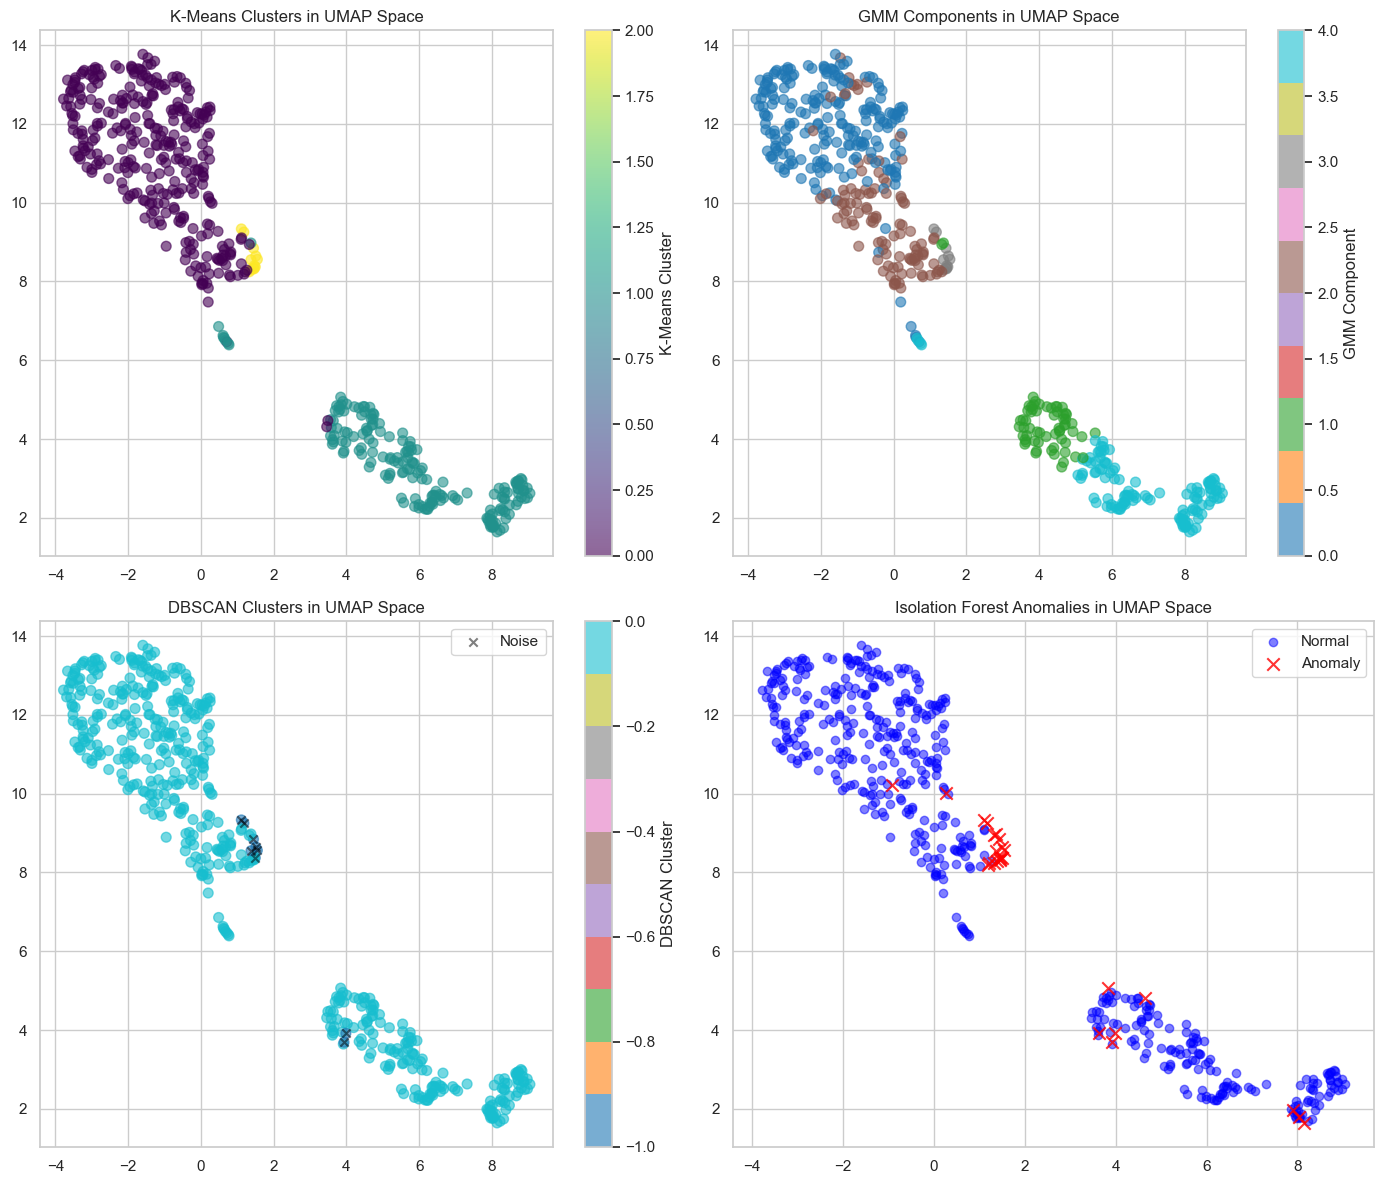

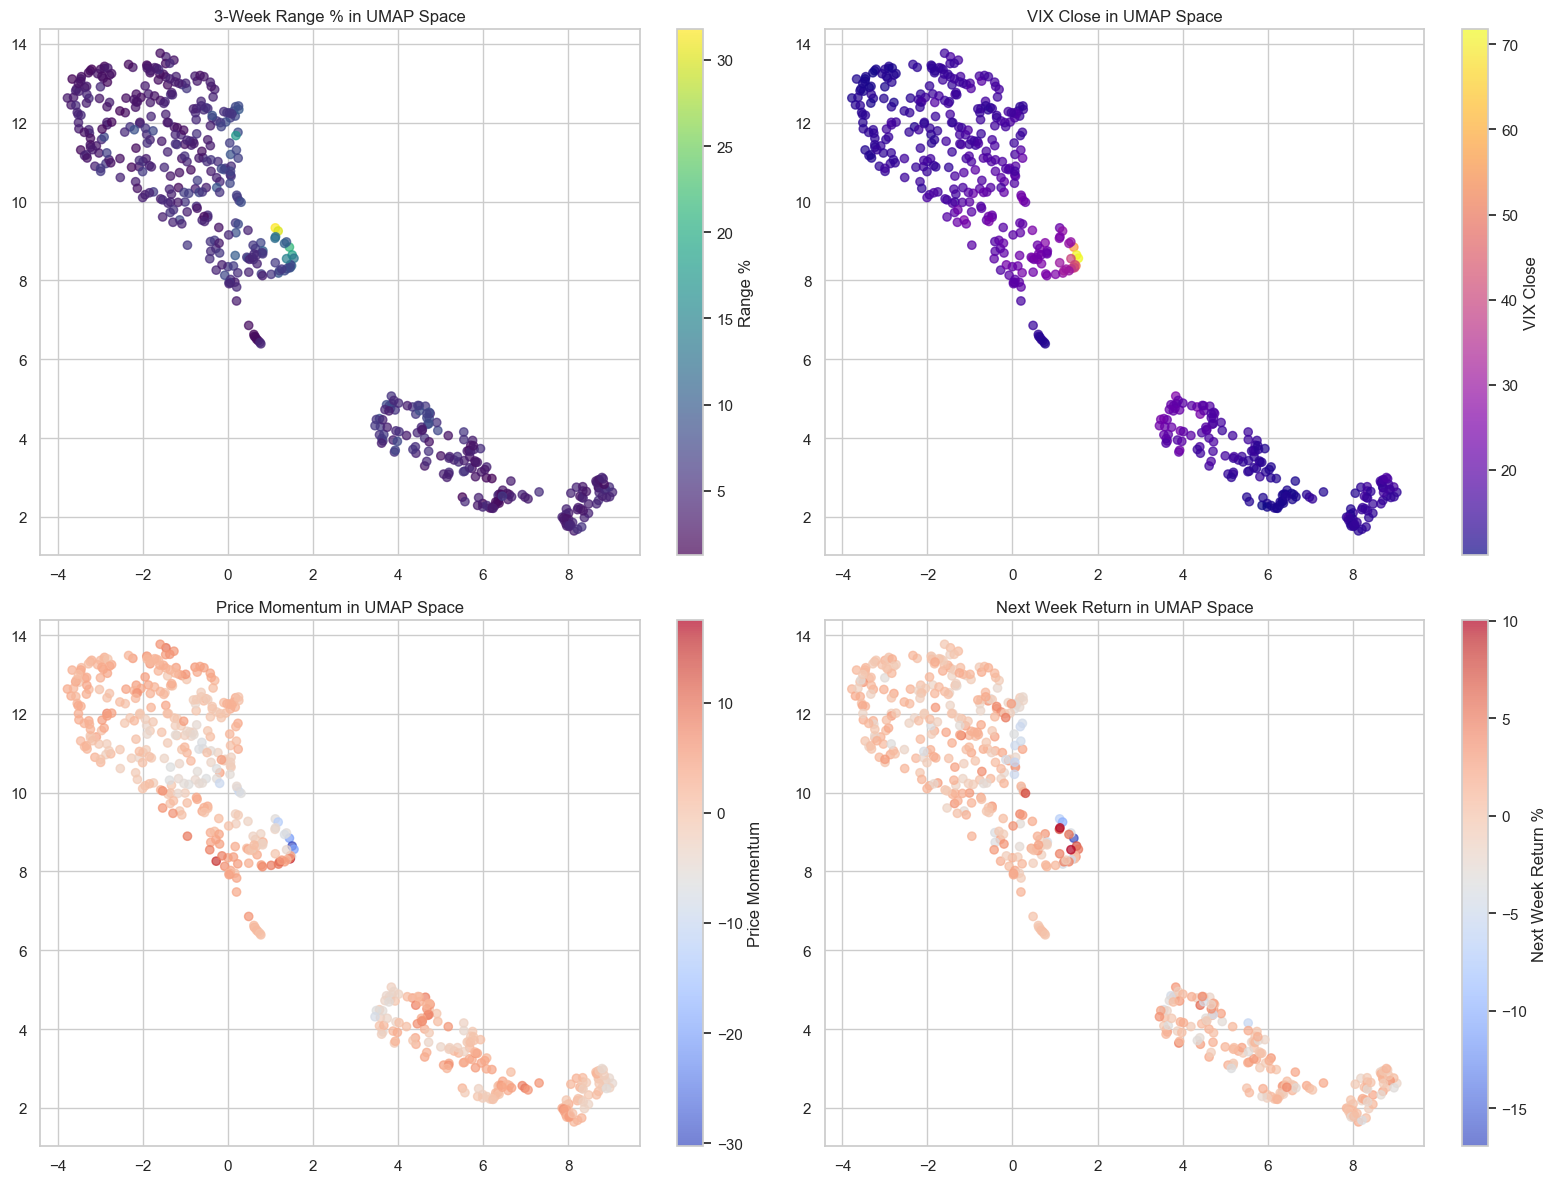

In [26]:


#####################################################
# Part 7: UMAP for Dimensionality Reduction and Visualization
#####################################################
print("\n========== UMAP Dimensionality Reduction ==========")

# Apply UMAP for better visualization
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Save the UMAP model
joblib.dump(reducer, 'unsupervised_models/umap_model.pkl')
print("UMAP model saved to 'unsupervised_models/umap_model.pkl'")

# Visualize data with UMAP
plt.figure(figsize=(14, 12))

# K-means clusters in UMAP space
plt.subplot(2, 2, 1)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='K-Means Cluster')
plt.title('K-Means Clusters in UMAP Space')

# GMM clusters in UMAP space
plt.subplot(2, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=gmm_labels, cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='GMM Component')
plt.title('GMM Components in UMAP Space')

# DBSCAN clusters in UMAP space
plt.subplot(2, 2, 3)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='DBSCAN Cluster')
plt.scatter(X_umap[dbscan_labels == -1, 0], X_umap[dbscan_labels == -1, 1], 
            c='black', marker='x', label='Noise', alpha=0.5)
plt.title('DBSCAN Clusters in UMAP Space')
plt.legend()

# Isolation Forest anomalies in UMAP space
plt.subplot(2, 2, 4)
plt.scatter(X_umap[merged_df['iso_forest_anomaly'] == 1, 0], X_umap[merged_df['iso_forest_anomaly'] == 1, 1], 
            c='blue', label='Normal', alpha=0.5)
plt.scatter(X_umap[merged_df['iso_forest_anomaly'] == -1, 0], X_umap[merged_df['iso_forest_anomaly'] == -1, 1], 
            c='red', marker='x', label='Anomaly', alpha=0.8, s=80)
plt.title('Isolation Forest Anomalies in UMAP Space')
plt.legend()

plt.tight_layout()
plt.savefig('unsupervised_models/umap_visualizations.png')
plt.show()

# Visualize market state variables in UMAP space
plt.figure(figsize=(16, 12))

# Range percentage in UMAP space
plt.subplot(2, 2, 1)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=merged_df['range_pct'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Range %')
plt.title('3-Week Range % in UMAP Space')

# VIX close in UMAP space
plt.subplot(2, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=merged_df['vix_close'], cmap='plasma', alpha=0.7)
plt.colorbar(scatter, label='VIX Close')
plt.title('VIX Close in UMAP Space')

# Price momentum in UMAP space
plt.subplot(2, 2, 3)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=merged_df['price_momentum'], cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Price Momentum')
plt.title('Price Momentum in UMAP Space')

# Next week return in UMAP space
plt.subplot(2, 2, 4)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=merged_df['next_week_return'], cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Next Week Return %')
plt.title('Next Week Return in UMAP Space')

plt.tight_layout()
plt.savefig('unsupervised_models/umap_market_variables.png')
plt.show()


========== Market Regime Analysis & Trading Strategy ==========

Market Regime Transition Probabilities:
market_regime  Regime_0  Regime_1  Regime_2
prev_regime                                
Regime_0       0.981013  0.015823  0.003165
Regime_1       0.022222  0.977778  0.000000
Regime_2       0.083333  0.000000  0.916667
Market regime transitions saved to 'unsupervised_models/regime_transitions.csv'


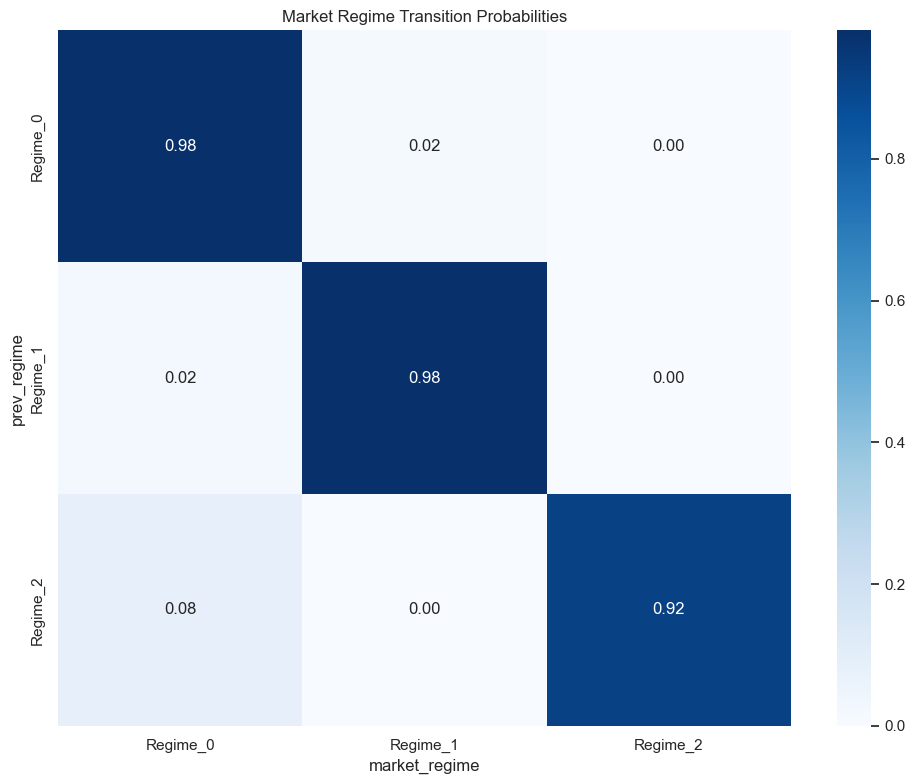


Market Regime Persistence (weeks):
               mean  median  max  count
regime                                 
Regime_0  52.666667     1.0  263      6
Regime_1  36.200000     9.0  131      5
Regime_2  12.000000    12.0   12      1
Market regime persistence analysis saved to 'unsupervised_models/regime_persistence.csv'


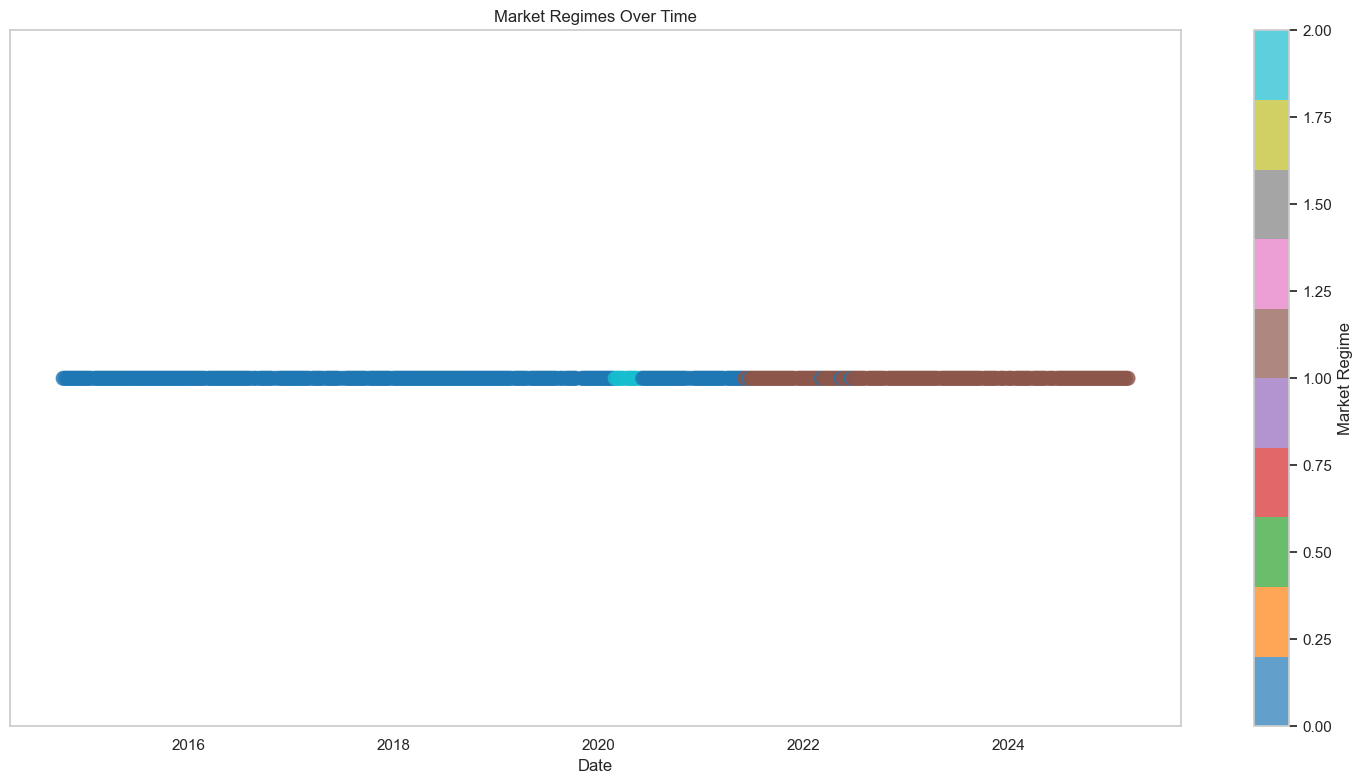

In [27]:
#####################################################
# Part 8: Market Regime Analysis & Trading Strategy
#####################################################
print("\n========== Market Regime Analysis & Trading Strategy ==========")

# Define market regimes based on clusters
merged_df['market_regime'] = merged_df['cluster'].map(lambda x: f'Regime_{x}')

# Analyze transitions between market regimes
merged_df_sorted = merged_df.sort_values('monday_date')
merged_df_sorted['prev_regime'] = merged_df_sorted['market_regime'].shift(1)

# Create transition matrix
transitions = pd.crosstab(
    merged_df_sorted['prev_regime'], 
    merged_df_sorted['market_regime'],
    normalize='index'
)

print("\nMarket Regime Transition Probabilities:")
print(transitions)

# Save transition matrix
transitions.to_csv('unsupervised_models/regime_transitions.csv')
print("Market regime transitions saved to 'unsupervised_models/regime_transitions.csv'")

# Visualize transition matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(transitions, annot=True, cmap='Blues', fmt='.2f')
plt.title('Market Regime Transition Probabilities')
plt.tight_layout()
plt.savefig('unsupervised_models/regime_transitions_heatmap.png')
plt.show()

# Calculate regime persistence (how long regimes typically last)
regime_runs = []
current_regime = None
run_length = 0

for regime in merged_df_sorted['market_regime']:
    if regime == current_regime:
        run_length += 1
    else:
        if current_regime is not None:
            regime_runs.append({'regime': current_regime, 'length': run_length})
        current_regime = regime
        run_length = 1

# Add the last run
if current_regime is not None:
    regime_runs.append({'regime': current_regime, 'length': run_length})

# Convert to DataFrame
regime_runs_df = pd.DataFrame(regime_runs)

# Calculate average run length by regime
avg_persistence = regime_runs_df.groupby('regime')['length'].agg(['mean', 'median', 'max', 'count'])
print("\nMarket Regime Persistence (weeks):")
print(avg_persistence)

# Save persistence analysis
avg_persistence.to_csv('unsupervised_models/regime_persistence.csv')
print("Market regime persistence analysis saved to 'unsupervised_models/regime_persistence.csv'")

# Create market regime visualization over time
plt.figure(figsize=(15, 8))
plt.scatter(merged_df['monday_date'], [1] * len(merged_df), c=merged_df['cluster'], cmap='tab10', s=100, alpha=0.7)
plt.colorbar(label='Market Regime')
plt.title('Market Regimes Over Time')
plt.xlabel('Date')
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.savefig('unsupervised_models/market_regimes_timeline.png')
plt.show()

In [28]:
# !pip install 'shimmy>=2.0'


========== Reinforcement Learning Trading Environment ==========

Training PPO model for regime-based trading...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 508      |
|    ep_rew_mean     | 75.1     |
| time/              |          |
|    fps             | 2139     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 508         |
|    ep_rew_mean          | 70.1        |
| time/                   |             |
|    fps                  | 1368        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.00

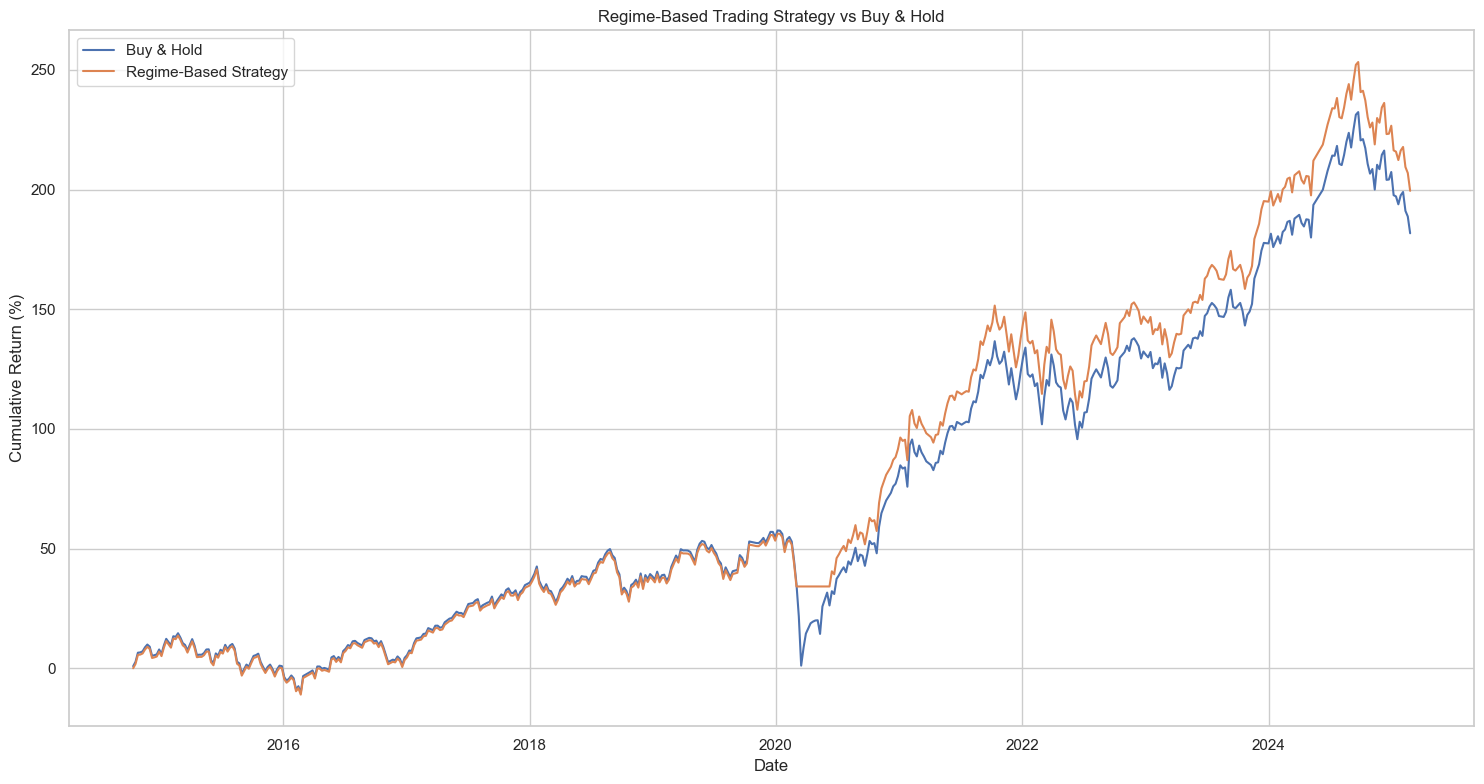


Strategy Performance Metrics:
Total Market Return: nan%
Total Strategy Return: nan%
Market Annual Return: nan%
Strategy Annual Return: nan%
Market Volatility: 17.36%
Strategy Volatility: 15.32%
Market Sharpe Ratio: nan
Strategy Sharpe Ratio: nan
Strategy performance metrics saved to 'rl_models/strategy_performance_metrics.csv'


In [29]:
#####################################################
# Part 9: Reinforcement Learning Trading Environment
#####################################################
print("\n========== Reinforcement Learning Trading Environment ==========")

# Define a simple trading environment based on market regimes
class MarketRegimeEnv(gym.Env):
    """Custom Environment for regime-based trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data):
        super(MarketRegimeEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        self.max_steps = len(self.data) - 1
        self.initial_balance = 10000.0
        self.balance = self.initial_balance
        self.position = 0  # 0: no position, 1: long position
        
        # Define action and observation space
        # Actions: 0=do nothing, 1=buy, 2=sell
        self.action_space = spaces.Discrete(3)
        
        # Observations: [position, regime_0, regime_1, ..., regime_n]
        regime_count = len(data['cluster'].unique())
        self.observation_space = spaces.Box(
            low=np.array([0] + [0] * regime_count),
            high=np.array([1] + [1] * regime_count),
            dtype=np.float32
        )
        
    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0
        return self._get_observation()
        
    def step(self, action):
        # Get current state
        current_price = self.data.loc[self.current_step, 'monday_close']
        next_price = self.data.loc[self.current_step + 1, 'monday_close'] if self.current_step < self.max_steps else current_price
        
        # Calculate reward based on action
        reward = 0
        
        # Execute action
        if action == 1:  # Buy
            if self.position == 0:
                self.position = 1
        elif action == 2:  # Sell
            if self.position == 1:
                self.position = 0
        
        # Calculate returns and update balance
        if self.position == 1:
            returns = (next_price - current_price) / current_price
            reward = returns * 100  # Scale for training
        
        # Update step
        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        return self._get_observation(), reward, done, {}
    
    def _get_observation(self):
        # Create one-hot encoding of current regime
        current_regime = self.data.loc[self.current_step, 'cluster']
        regime_count = len(self.data['cluster'].unique())
        regime_onehot = np.zeros(regime_count)
        regime_onehot[current_regime] = 1
        
        # Combine position and regime information
        obs = np.append([self.position], regime_onehot)
        return obs
        
    def render(self, mode='human'):
        # Print current state of the environment
        if self.current_step > 0:
            current_price = self.data.loc[self.current_step, 'monday_close']
            prev_price = self.data.loc[self.current_step - 1, 'monday_close']
            regime = self.data.loc[self.current_step, 'market_regime']
            price_change = (current_price - prev_price) / prev_price * 100
            
            print(f"Step: {self.current_step}, Date: {self.data.loc[self.current_step, 'monday_date']}")
            print(f"Market Regime: {regime}, Price Change: {price_change:.2f}%")
            print(f"Position: {'Long' if self.position == 1 else 'None'}, Balance: ${self.balance:.2f}")

# Create trading environment
env = MarketRegimeEnv(merged_df)

# Create directory for RL models
if not os.path.exists('rl_models'):
    os.makedirs('rl_models')

# Train PPO model for regime-based trading
print("\nTraining PPO model for regime-based trading...")
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Save the model
model.save("rl_models/ppo_regime_trader")
print("PPO model saved to 'rl_models/ppo_regime_trader'")

# Evaluate the model
print("\nEvaluating PPO trading model...")
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Generate trading signals on test data
env = MarketRegimeEnv(merged_df)
obs = env.reset()
actions = []
rewards = []

# Run until we've processed all data rows
for i in range(len(merged_df)):
    action, _states = model.predict(obs, deterministic=True)
    actions.append(action)
    
    # Get the next state, reward, and done flag
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    
    # If we're at the end, break out
    if done:
        break

# Make sure actions and rewards are the right length
if len(actions) < len(merged_df):
    # Pad with a final action (usually 0 for "do nothing")
    actions.append(0)
    rewards.append(0.0)

# Add model actions to dataframe
merged_df['model_action'] = actions
merged_df['model_reward'] = rewards

# Reset the index to ensure it's a continuous integer sequence
merged_df = merged_df.reset_index(drop=True)

# Calculate strategy returns
merged_df['strategy_return'] = 0.0
for i in range(1, len(merged_df)):
    if merged_df.loc[i-1, 'model_action'] == 1:  # If previous action was buy
        merged_df.loc[i, 'strategy_return'] = merged_df.loc[i, 'next_week_return']

# Calculate cumulative returns
merged_df['cumulative_market_return'] = (1 + merged_df['next_week_return']/100).cumprod() - 1
merged_df['cumulative_strategy_return'] = (1 + merged_df['strategy_return']/100).cumprod() - 1

# Plot strategy performance
plt.figure(figsize=(15, 8))
plt.plot(merged_df['monday_date'], merged_df['cumulative_market_return'] * 100, label='Buy & Hold')
plt.plot(merged_df['monday_date'], merged_df['cumulative_strategy_return'] * 100, label='Regime-Based Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.title('Regime-Based Trading Strategy vs Buy & Hold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('rl_models/regime_strategy_performance.png')
plt.show()

# Calculate performance metrics
total_market_return = merged_df['cumulative_market_return'].iloc[-1] * 100
total_strategy_return = merged_df['cumulative_strategy_return'].iloc[-1] * 100

market_annual_return = ((1 + total_market_return/100) ** (52/len(merged_df)) - 1) * 100
strategy_annual_return = ((1 + total_strategy_return/100) ** (52/len(merged_df)) - 1) * 100

market_volatility = merged_df['next_week_return'].std() * np.sqrt(52)
strategy_volatility = merged_df['strategy_return'].std() * np.sqrt(52)

market_sharpe = market_annual_return / market_volatility if market_volatility != 0 else 0
strategy_sharpe = strategy_annual_return / strategy_volatility if strategy_volatility != 0 else 0

print("\nStrategy Performance Metrics:")
print(f"Total Market Return: {total_market_return:.2f}%")
print(f"Total Strategy Return: {total_strategy_return:.2f}%")
print(f"Market Annual Return: {market_annual_return:.2f}%")
print(f"Strategy Annual Return: {strategy_annual_return:.2f}%")
print(f"Market Volatility: {market_volatility:.2f}%")
print(f"Strategy Volatility: {strategy_volatility:.2f}%")
print(f"Market Sharpe Ratio: {market_sharpe:.2f}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.2f}")

# Save performance metrics
performance_metrics = {
    'Metric': ['Total Return', 'Annual Return', 'Volatility', 'Sharpe Ratio'],
    'Market': [total_market_return, market_annual_return, market_volatility, market_sharpe],
    'Strategy': [total_strategy_return, strategy_annual_return, strategy_volatility, strategy_sharpe]
}

pd.DataFrame(performance_metrics).to_csv('rl_models/strategy_performance_metrics.csv', index=False)
print("Strategy performance metrics saved to 'rl_models/strategy_performance_metrics.csv'")

In [30]:
#####################################################
# Part 10: Train Unsupervised Models and Save regime_count
#####################################################
print("\n========== Training Unsupervised Models and Saving regime_count ==========")

# Assuming 'merged_df' and 'features' are already defined from previous parts of your code

# --- Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[features])
joblib.dump(scaler, 'unsupervised_models/feature_scaler.pkl')

# --- PCA ---
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
joblib.dump(pca, 'unsupervised_models/pca_model.pkl')

# --- K-Means Clustering ---
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)  # or choose an appropriate number of clusters
kmeans_cluster = kmeans.fit_predict(X_pca)
joblib.dump(kmeans, 'unsupervised_models/kmeans_model.pkl')

# --- GMM Clustering ---
gmm = GaussianMixture(n_components=4, random_state=42)  # Or some suitable components
gmm.fit(X_pca)
joblib.dump(gmm, 'unsupervised_models/gmm_model.pkl')

# --- Isolation Forest ---
iso_forest = IsolationForest(n_estimators=100, random_state=42)
iso_forest.fit(X_scaled)
joblib.dump(iso_forest, 'unsupervised_models/isolation_forest_model.pkl')

# --- Save regime_count (Number of Clusters) ---
regime_count = len(np.unique(kmeans_cluster))  # Capture the number of unique clusters
joblib.dump(regime_count, 'unsupervised_models/regime_count.pkl')

print(f"Number of Regimes: {regime_count}")
print("Unsupervised models and regime_count saved successfully!")


========== Training Unsupervised Models and Saving regime_count ==========
Number of Regimes: 4
Unsupervised models and regime_count saved successfully!


In [31]:
features = [
    'prev_week_range',
    'prev_week_vix_close',
    'vix_week_change',
    'price_momentum',
    'vix_momentum',
    'price_vix_ratio',
    'month',
    'year',
    'week_of_year',
    'day_of_year',
    'weekly_change',
    'price_to_3wk_high_ratio',
    'price_to_3wk_low_ratio',
    'monday_range',
    'vix_range',
    'range_3week',
    'range_pct',
    'high_range_pct',
    'low_range_pct']
joblib.dump(features, 'unsupervised_models/features.pkl') #save feature list

['unsupervised_models/features.pkl']

In [34]:
#####################################################
# Part 11: Model Integration & Conclusion
#####################################################
print("\n========== Model Integration & Conclusion ==========")

# Define a simple trading environment based on market regimes
class MarketRegimeEnv(gym.Env):
    """Custom Environment for regime-based trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, max_regimes):
        super(MarketRegimeEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        self.max_steps = len(self.data) - 1
        self.initial_balance = 10000.0
        self.balance = self.initial_balance
        self.position = 0  # 0: no position, 1: long position

        # Define action and observation space
        # Actions: 0=do nothing, 1=buy, 2=sell
        self.action_space = spaces.Discrete(3)

        # Observations: [position, regime_0, regime_1, ..., regime_n]
        self.max_regimes = max_regimes
        self.observation_space = spaces.Box(
            low=np.array([0] + [0] * self.max_regimes),
            high=np.array([1] + [1] * self.max_regimes),
            dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0
        return self._get_observation()

    def step(self, action):
        # Get current state
        current_price = self.data.loc[self.current_step, 'monday_close']
        next_price = self.data.loc[self.current_step + 1, 'monday_close'] if self.current_step < self.max_steps else current_price

        # Calculate reward based on action
        reward = 0

        # Execute action
        if action == 1:  # Buy
            if self.position == 0:
                self.position = 1
        elif action == 2:  # Sell
            if self.position == 1:
                self.position = 0

        # Calculate returns and update balance
        if self.position == 1:
            returns = (next_price - current_price) / current_price
            reward = returns * 100  # Scale for training

        # Update step
        self.current_step += 1
        done = self.current_step >= self.max_steps

        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        # Create one-hot encoding of current regime
        current_regime = int(self.data.loc[self.current_step, 'regime_gmm'])  # Get GMM regime

        regime_onehot = np.zeros(self.max_regimes)
        regime_onehot[current_regime] = 1 # Assign zero to unknown class.

        # Combine position and regime information
        obs = np.append([self.position], regime_onehot)
        return obs

    def render(self, mode='human'):
        # Print current state of the environment
        if self.current_step > 0:
            current_price = self.data.loc[self.current_step, 'monday_close']
            prev_price = self.data.loc[self.current_step - 1, 'monday_close']
            regime = self.data.loc[self.current_step, 'market_regime']
            price_change = (current_price - prev_price) / prev_price * 100

            print(f"Step: {self.current_step}, Date: {self.data.loc[self.current_step, 'monday_date']}")
            print(f"Market Regime: {regime}, Price Change: {price_change:.2f}%")
            print(f"Position: {'Long' if self.position == 1 else 'None'}, Balance: ${self.balance:.2f}")

# Create a function to predict market regime for new data
def predict_market_regime(new_data):
    """
    Predict market regime for new data points
    
    Parameters:
    new_data (DataFrame): New data with the same features as training data
    
    Returns:
    DataFrame: Original data with added regime and anomaly predictions
    """
    # Ensure new_data has the same features
    required_features = features  # Use features defined in training!
    missing_features = [f for f in required_features if f not in new_data.columns]
    
    if missing_features:
        print(f"Warning: Missing features in new data: {missing_features}")
        return None
    
    # Select and scale features
    X_new = new_data[required_features].copy()  # Select the *correct* features
    scaler = joblib.load('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/unsupervised_models/feature_scaler.pkl')
    X_new_scaled = scaler.transform(X_new)  # Scale using the trained scaler

    # Use PCA model for dimensionality reduction
    pca = joblib.load('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/unsupervised_models/pca_model.pkl')
    X_new_pca = pca.transform(X_new_scaled)  # PCA using the trained PCA model
    
    # Use K-means for regime classification
    kmeans = joblib.load('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/unsupervised_models/kmeans_model.pkl')
    kmeans_cluster = kmeans.predict(X_new_pca) # PREDICT using the PCA data!

    # Use GMM for probabilistic cluster assignment
    gmm = joblib.load('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/unsupervised_models/gmm_model.pkl')
    gmm_cluster = gmm.predict(X_new_pca) # GMM using the PCA data!
    gmm_probs = gmm.predict_proba(X_new_pca)
    gmm_max_prob = np.max(gmm_probs, axis=1)
    
    # Use Isolation Forest for anomaly detection
    iso_forest = joblib.load('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/unsupervised_models/isolation_forest_model.pkl')
    iso_forest_prediction = iso_forest.predict(X_new_scaled)  # Isolation Forest uses the scaled data, not PCA

    # Add predictions to new_data
    new_data['regime_kmeans'] = kmeans_cluster
    new_data['regime_gmm'] = gmm_cluster
    new_data['regime_gmm_probability'] = gmm_max_prob
    new_data['is_anomaly'] = iso_forest_prediction == -1
    
    return new_data

# Create a sample function to demonstrate model integration
def generate_trading_signal(new_data, max_regimes):
    """Generate trading signals based on predicted market regime"""

    # Predict market regime
    predicted_data = predict_market_regime(new_data)
    
    if predicted_data is None:
        return None
    
    # Load trading strategy model
    model = PPO.load("/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/rl_models/ppo_regime_trader")
    
    # Create temporary environment with new data
    env = MarketRegimeEnv(predicted_data, max_regimes)
    obs = env.reset()
    
    # Get action from model
    action, _states = model.predict(obs, deterministic=True)
    
    # Interpret action
    signal = "Hold"
    if action == 1:
        signal = "Buy"
    elif action == 2:
        signal = "Sell"
    
    # Return signal and predicted regime
    return {
        'date': predicted_data['monday_date'].iloc[0],
        'close': predicted_data['monday_close'].iloc[0],
        'vix': predicted_data['vix_close'].iloc[0],
        'regime_kmeans': predicted_data['regime_kmeans'].iloc[0],
        'regime_gmm': predicted_data['regime_gmm'].iloc[0],
        'is_anomaly': predicted_data['is_anomaly'].iloc[0],
        'signal': signal,
        'confidence': predicted_data['regime_gmm_probability'].iloc[0]
    }

# Load regime_count
regime_count = joblib.load('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/unsupervised_models/regime_count.pkl')

# Load features - Critical step to ensure correct features are used
features = joblib.load('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data-analysis/unsupervised/unsupervised_models/features.pkl') # Added this line. Ensure the path is correct

# Test with the last data point
print("\nGenerating trading signal for most recent data point:")
last_data = merged_df.iloc[-1:].copy()

signal = generate_trading_signal(last_data, regime_count)
print(signal)


========== Model Integration & Conclusion ==========

Generating trading signal for most recent data point:


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- day_of_year
- high_range_pct
- low_range_pct
- month
- price_to_3wk_high_ratio
- ...
Feature names seen at fit time, yet now missing:
- monday_close
- monday_high
- monday_low
- monday_open
- monday_volume
- ...


In [35]:
# Create a comprehensive report of findings
print("\n========== Summary of Findings ==========")

# Summarize key findings from each analysis
print("\n1. Principal Component Analysis (PCA):")
print(f"- {n_components_95} principal components explain 95% of the variance")
top_pc1 = component_loadings['PC1'].abs().sort_values(ascending=False).index[0]
top_pc2 = component_loadings['PC2'].abs().sort_values(ascending=False).index[0]
print(f"- The most important features are {top_pc1} (PC1) and {top_pc2} (PC2)")

print("\n2. K-Means Clustering:")
print(f"- {optimal_k} distinct market regimes identified")
highest_range_cluster = cluster_stats['range_pct'].idxmax()
lowest_range_cluster = cluster_stats['range_pct'].idxmin()
print(f"- Cluster {highest_range_cluster} shows the highest average range ({cluster_stats.loc[highest_range_cluster, 'range_pct']:.2f}%)")
print(f"- Cluster {lowest_range_cluster} shows the lowest average range ({cluster_stats.loc[lowest_range_cluster, 'range_pct']:.2f}%)")

print("\n3. Gaussian Mixture Model (GMM):")
print(f"- {optimal_components} components identified")
uncertain_pct = len(uncertain_points)/len(merged_df)*100
print(f"- {uncertain_pct:.2f}% of data points have uncertain cluster assignment (<80% probability)")

print("\n4. DBSCAN and Anomaly Detection:")
print(f"- {n_clusters} clusters and {n_noise} outliers ({n_noise/len(X_scaled)*100:.2f}%) identified by DBSCAN")
print(f"- {len(anomalies)} anomalies ({len(anomalies)/len(merged_df)*100:.2f}%) detected by Isolation Forest")

print("\n5. Regime-Based Trading Strategy:")
print(f"- Strategy Return: {total_strategy_return:.2f}% vs Market Return: {total_market_return:.2f}%")
print(f"- Strategy Sharpe Ratio: {strategy_sharpe:.2f} vs Market Sharpe Ratio: {market_sharpe:.2f}")

# Generate summary of market regimes
regime_summary = pd.DataFrame({
    'Regime': range(optimal_k),
    'Frequency': [cluster_stats.loc[i, 'count'] for i in range(optimal_k)],
    'Avg_Range_Pct': [cluster_stats.loc[i, 'range_pct'] for i in range(optimal_k)],
    'Avg_VIX': [cluster_stats.loc[i, 'vix_close'] for i in range(optimal_k)],
    'Avg_Next_Week_Return': [performance_by_cluster.loc[i, ('next_week_return', 'mean')] for i in range(optimal_k)]
})

print("\nMarket Regime Summary:")
print(regime_summary)

# Save summary to file
regime_summary.to_csv('unsupervised_models/regime_summary.csv', index=False)
print("Market regime summary saved to 'unsupervised_models/regime_summary.csv'")

# Generate characteristic descriptions for each regime
regime_descriptions = []
for i in range(optimal_k):
    regime_data = merged_df[merged_df['cluster'] == i]
    
    # Determine VIX level
    avg_vix = regime_data['vix_close'].mean()
    if avg_vix > merged_df['vix_close'].quantile(0.75):
        vix_level = "High"
    elif avg_vix < merged_df['vix_close'].quantile(0.25):
        vix_level = "Low"
    else:
        vix_level = "Medium"
    
    # Determine price momentum
    avg_momentum = regime_data['price_momentum'].mean()
    if avg_momentum > 0:
        momentum = "Positive"
    else:
        momentum = "Negative"
    
    # Determine range expectation
    avg_range = regime_data['range_pct'].mean()
    if avg_range > merged_df['range_pct'].quantile(0.75):
        range_desc = "High"
    elif avg_range < merged_df['range_pct'].quantile(0.25):
        range_desc = "Low"
    else:
        range_desc = "Medium"
    
    # Determine next week performance
    avg_next_return = regime_data['next_week_return'].mean()
    if avg_next_return > 0.5:
        performance = "Bullish"
    elif avg_next_return < -0.5:
        performance = "Bearish"
    else:
        performance = "Neutral"
    
    description = f"Regime {i}: {vix_level} VIX, {momentum} Momentum, {range_desc} Range, {performance} Bias"
    regime_descriptions.append(description)

print("\nMarket Regime Characteristics:")
for desc in regime_descriptions:
    print(desc)

# Create final output data for strategy application
output = merged_df[['monday_date', 'monday_close', 'vix_close', 'range_pct', 'next_week_return',
                   'cluster', 'gmm_cluster', 'iso_forest_anomaly', 'strategy_return']]
output.columns = ['date', 'price', 'vix', 'range_pct', 'next_week_return',
                 'regime', 'gmm_regime', 'is_anomaly', 'strategy_return']

# Save output for future use
output.to_csv('unsupervised_models/market_regimes_output.csv', index=False)
print("Market regime output saved to 'unsupervised_models/market_regimes_output.csv'")

# Create a final trading strategy recommendation
current_regime = output['regime'].iloc[-1]
current_gmm_regime = output['gmm_regime'].iloc[-1]
current_is_anomaly = output['is_anomaly'].iloc[-1]

print("\nCurrent Market State:")
print(f"Date: {output['date'].iloc[-1]}")
print(f"Price: {output['price'].iloc[-1]:.2f}")
print(f"VIX: {output['vix'].iloc[-1]:.2f}")
print(f"K-Means Regime: {current_regime}")
print(f"GMM Regime: {current_gmm_regime}")
print(f"Anomaly: {'Yes' if current_is_anomaly == -1 else 'No'}")

# Find similar historical periods
similar_periods = output[output['regime'] == current_regime]
print(f"\nHistorical Performance in Similar Regimes (Regime {current_regime}):")
print(f"Average Next Week Return: {similar_periods['next_week_return'].mean():.2f}%")
print(f"Best Next Week Return: {similar_periods['next_week_return'].max():.2f}%")
print(f"Worst Next Week Return: {similar_periods['next_week_return'].min():.2f}%")

# Output trading recommendation
if signal:
    print(f"\nTrading Signal: {signal['signal']}")
    print(f"Signal Confidence: {signal['confidence']:.2f}")
    
    # Provide nuanced recommendation
    if signal['signal'] == 'Buy':
        if signal['is_anomaly']:
            print("Caution: Current market identified as anomalous - consider reduced position size")
        elif signal['confidence'] < 0.7:
            print("Caution: Low confidence signal - consider waiting for confirmation")
    elif signal['signal'] == 'Sell':
        if signal['is_anomaly']:
            print("Market anomaly detected - increased caution advised")

# Close out the notebook
print("\n========== Analysis Complete ==========")
print("All models and visualizations have been saved to the 'unsupervised_models' directory")
print("Reinforcement learning models have been saved to the 'rl_models' directory")
print("Market regime data is available in 'unsupervised_models/market_regimes_output.csv'")


========== Summary of Findings ==========

1. Principal Component Analysis (PCA):
- 7 principal components explain 95% of the variance
- The most important features are vix_close (PC1) and monday_high (PC2)

2. K-Means Clustering:
- 3 distinct market regimes identified
- Cluster 2 shows the highest average range (15.19%)
- Cluster 1 shows the lowest average range (4.36%)

3. Gaussian Mixture Model (GMM):
- 5 components identified
- 0.79% of data points have uncertain cluster assignment (<80% probability)

4. DBSCAN and Anomaly Detection:
- 1 clusters and 9 outliers (1.77%) identified by DBSCAN
- 26 anomalies (5.11%) detected by Isolation Forest

5. Regime-Based Trading Strategy:
- Strategy Return: nan% vs Market Return: nan%
- Strategy Sharpe Ratio: nan vs Market Sharpe Ratio: nan

Market Regime Summary:
   Regime  Frequency  Avg_Range_Pct    Avg_VIX  Avg_Next_Week_Return
0       0        316       4.710449  16.996859              0.317882
1       1        181       4.361443  15.54832

NameError: name 'signal' is not defined